In [1]:
# Importing necessary libraries
import glob
import os
import re
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
import holidays
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

%matplotlib inline

In [2]:
# Function to merge file paths from subdirectories
def merge_paths(data_folder):

    lst = os.listdir(data_folder)

    data_paths = []
    for data in lst:
        print(data)
        path = glob.glob(os.path.join(data_folder, data, "*.xlsx"))
        if len(path) != 0:

            data_paths.append(path)
        print(path)
    
    return data_paths

def data_merger(data_paths, data_saving_path):
    DATE_COLUMN_NAME = 'Date'

    master_dfs_to_join = []
    total_groups_processed = 0

    print("Starting group combination")

    for group_index, group_paths in enumerate(data_paths):
        group_dfs_list = []
        print(f"Processing Group {group_index + 1} with {len(group_paths)} files...")

        for file_path in group_paths:
            normalized_path = os.path.normpath(file_path)
            try:
                df = pd.read_excel(normalized_path, engine='openpyxl')
                group_dfs_list.append(df)
            except Exception as e:
                print(f"Error reading '{normalized_path}': {e}. Skipping.")

        if not group_dfs_list:
            print(f"Skipping Group {group_index + 1}: No files read successfully.")
            continue

        master_group_df = pd.concat(group_dfs_list, ignore_index=True)
        
        try:
            master_group_df[DATE_COLUMN_NAME] = pd.to_datetime(
                master_group_df[DATE_COLUMN_NAME], errors='coerce'
            )        
            master_group_df = master_group_df.dropna(subset=[DATE_COLUMN_NAME])
            master_group_df = master_group_df.set_index(DATE_COLUMN_NAME)
            
            master_dfs_to_join.append(master_group_df)
            total_groups_processed += 1
            print(f"Group {group_index + 1} appended and prepared for join (Rows: {len(master_group_df)}).")

        except KeyError:
            print(f"ERROR in Group {group_index + 1}!")
            print(f"Date column '{DATE_COLUMN_NAME}' not found. Please check column headers.")
            
    if total_groups_processed < 2:
        print("Cannot perform a join: Less than two metric groups were successfully processed.")
    else:
        
        final_combined_df = pd.concat(master_dfs_to_join, axis=1, join='outer')
        final_combined_df = final_combined_df.reset_index().rename(columns={'index': DATE_COLUMN_NAME})
        
        final_combined_df = final_combined_df.sort_values(by=DATE_COLUMN_NAME).reset_index(drop=True)

        OUTPUT_FILE_NAME = os.path.join(data_saving_path, 'Combined_Time_Series_Joined_Data.csv')
        final_combined_df.to_csv(OUTPUT_FILE_NAME, index=False)

        print(f"Final joined data saved to '{OUTPUT_FILE_NAME}'.")
        print(f"Final shape: {final_combined_df.shape}")
        print(f"Note: Missing values (NaN) in the output indicate a timestamp where a specific metric had no data.")

In [3]:
# Function to refine and clean the merged data
def data_refiner(data, data_saving_path):
    columns_to_drop = [
        'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 
        'Unnamed: 5.1', 'Unnamed: 6.1', 'Unnamed: 7.1', 'Unnamed: 8.1',
        'Cooling load (GJ)', 'Heating load (GJ)', 'Hot water load (GJ)',
        'Cooling load (GJ).1', 'Heating load (GJ).1', 'Hot water load (GJ).1',
        'Boiler (m3)', 'Fuel cell (m3)', 'Gas engine (m3)',
        'Absorption chiller 1 (m3)', 'Absorption chiller 2 (m3)', 'Absorption chiller 3 (m3)'
    ]

    renaming_map = {
        'Solar energy generation (kW)': 'PV_Generation_kW',
        'Electricity imported from grid (kW)': 'Grid_Import_kW',
        'Gas engine (kW)': 'GasEngine_Generation_kW',
        'Fuel cell (kW)': 'FuelCell_Generation_kW',        
        'Electricity load (kW)': 'Electric_Load_A_kW',      
        'Cooling load (kW)': 'Cooling_Load_A_kW',
        'Heating load (kW)': 'Heating_Load_A_kW',
        'Hot water load (kW)': 'HotWater_Load_A_kW',
        'Electricity load (kW).1': 'Electric_Load_B_kW', 
        'Cooling load (kW).1': 'Cooling_Load_B_kW',
        'Heating load (kW).1': 'Heating_Load_B_kW',
        'Hot water load (kW).1': 'HotWater_Load_B_kW',
        'Horizontal solar irradition (W)': 'Solar_Irradiation_W',
        'Outdoor air temperature (℃)': 'Outdoor_Air_Temp_C',
        'Outdoor air humidity (%)': 'Outdoor_Air_Humidity_percent',
        'Wind speed (m/s)': 'Wind_Speed_ms',
        'Wind direction': 'Wind_Direction_deg',
        'Gas 1(GJ/h)': 'Gas1_Input_GJh',
        'Gas 2(GJ/h)': 'Gas2_Input_GJh',
        'Fuel cell 1(GJ/h)': 'FuelCell1_Input_GJh',
        'Fuel cell 2(GJ/h)': 'FuelCell2_Input_GJh',
        'Fuel cell 3(GJ/h)': 'FuelCell3_Input_GJh'
    }


    final_combined_df = data.drop(columns=columns_to_drop, errors='ignore')
    print("Dropped empty/sparse/ambiguous columns.")

    final_combined_df = final_combined_df.rename(columns=renaming_map)
    print("Renamed remaining columns for clarity.")

    final_combined_df['Date'] = pd.to_datetime(final_combined_df['Date'], errors='coerce')
    initial_rows = len(final_combined_df)
    final_combined_df = final_combined_df.dropna(subset=['Date'])
    print(f"Removed {initial_rows - len(final_combined_df)} rows with missing or invalid 'Date'.")

    return final_combined_df





In [4]:
# Main execution of the data merging and refining process
data_save_path = '../Data_Output/'
os.makedirs(data_save_path, exist_ok=True)
data_folder = '../Project_data/' 
data_paths = merge_paths(data_folder)
data_merger(data_paths, data_save_path)

data = pd.read_csv(os.path.join(data_save_path, 'Combined_Time_Series_Joined_Data.csv'))
data = data_refiner(data, data_save_path)

Power
['../Project_data/Power/Power_time series__2012.xlsx', '../Project_data/Power/Power_time series__2004.xlsx', '../Project_data/Power/Power_time series__2008.xlsx', '../Project_data/Power/Power_time series__2009.xlsx', '../Project_data/Power/Power_time series__2005.xlsx', '../Project_data/Power/Power_time series__2013.xlsx', '../Project_data/Power/Power_time series__2018.xlsx', '../Project_data/Power/Power_time series__2022.xlsx', '../Project_data/Power/Power_time series__2014.xlsx', '../Project_data/Power/Power_time series__2002.xlsx', '../Project_data/Power/Power_time series__2003.xlsx', '../Project_data/Power/Power_time series__2015.xlsx', '../Project_data/Power/Power_time series__2019.xlsx', '../Project_data/Power/Power_time series__2020.xlsx', '../Project_data/Power/Power_time series__2016.xlsx', '../Project_data/Power/Power_time series__2017.xlsx', '../Project_data/Power/Power_time series__2001.xlsx', '../Project_data/Power/Power_time series__2021.xlsx', '../Project_data/Powe

In [5]:
# Display the first few rows and check for missing values
print(data.head())
print(data.isnull().sum())

                 Date  PV_Generation_kW  Grid_Import_kW  \
0 2001-06-01 00:00:00               0.0           249.0   
1 2001-06-01 01:00:00               0.0           254.0   
2 2001-06-01 02:00:00               0.0           223.0   
3 2001-06-01 03:00:00               0.0           232.0   
4 2001-06-01 04:00:00               0.0           235.0   

   GasEngine_Generation_kW  FuelCell_Generation_kW  Electric_Load_A_kW  \
0                      0.0                   194.0               443.0   
1                      0.0                   194.0               448.0   
2                      0.0                   194.0               417.0   
3                      0.0                   194.0               426.0   
4                      0.0                   194.0               429.0   

   Cooling_Load_A_kW  Heating_Load_A_kW  HotWater_Load_A_kW  \
0                0.0                0.0                21.0   
1                0.0                0.0                21.0   
2          

In [6]:
# Drop Building B load columns
data.drop(['Cooling_Load_B_kW','Heating_Load_B_kW','HotWater_Load_B_kW'], axis=1, inplace=True)

Found 19 numerical columns: ['PV_Generation_kW', 'Grid_Import_kW', 'GasEngine_Generation_kW', 'FuelCell_Generation_kW', 'Electric_Load_A_kW', 'Cooling_Load_A_kW', 'Heating_Load_A_kW', 'HotWater_Load_A_kW', 'Solar_Irradiation_W', 'Outdoor_Air_Temp_C', 'Outdoor_Air_Humidity_percent', 'Wind_Speed_ms', 'Wind_Direction_deg', 'Electric_Load_B_kW', 'Gas1_Input_GJh', 'Gas2_Input_GJh', 'FuelCell1_Input_GJh', 'FuelCell2_Input_GJh', 'FuelCell3_Input_GJh']


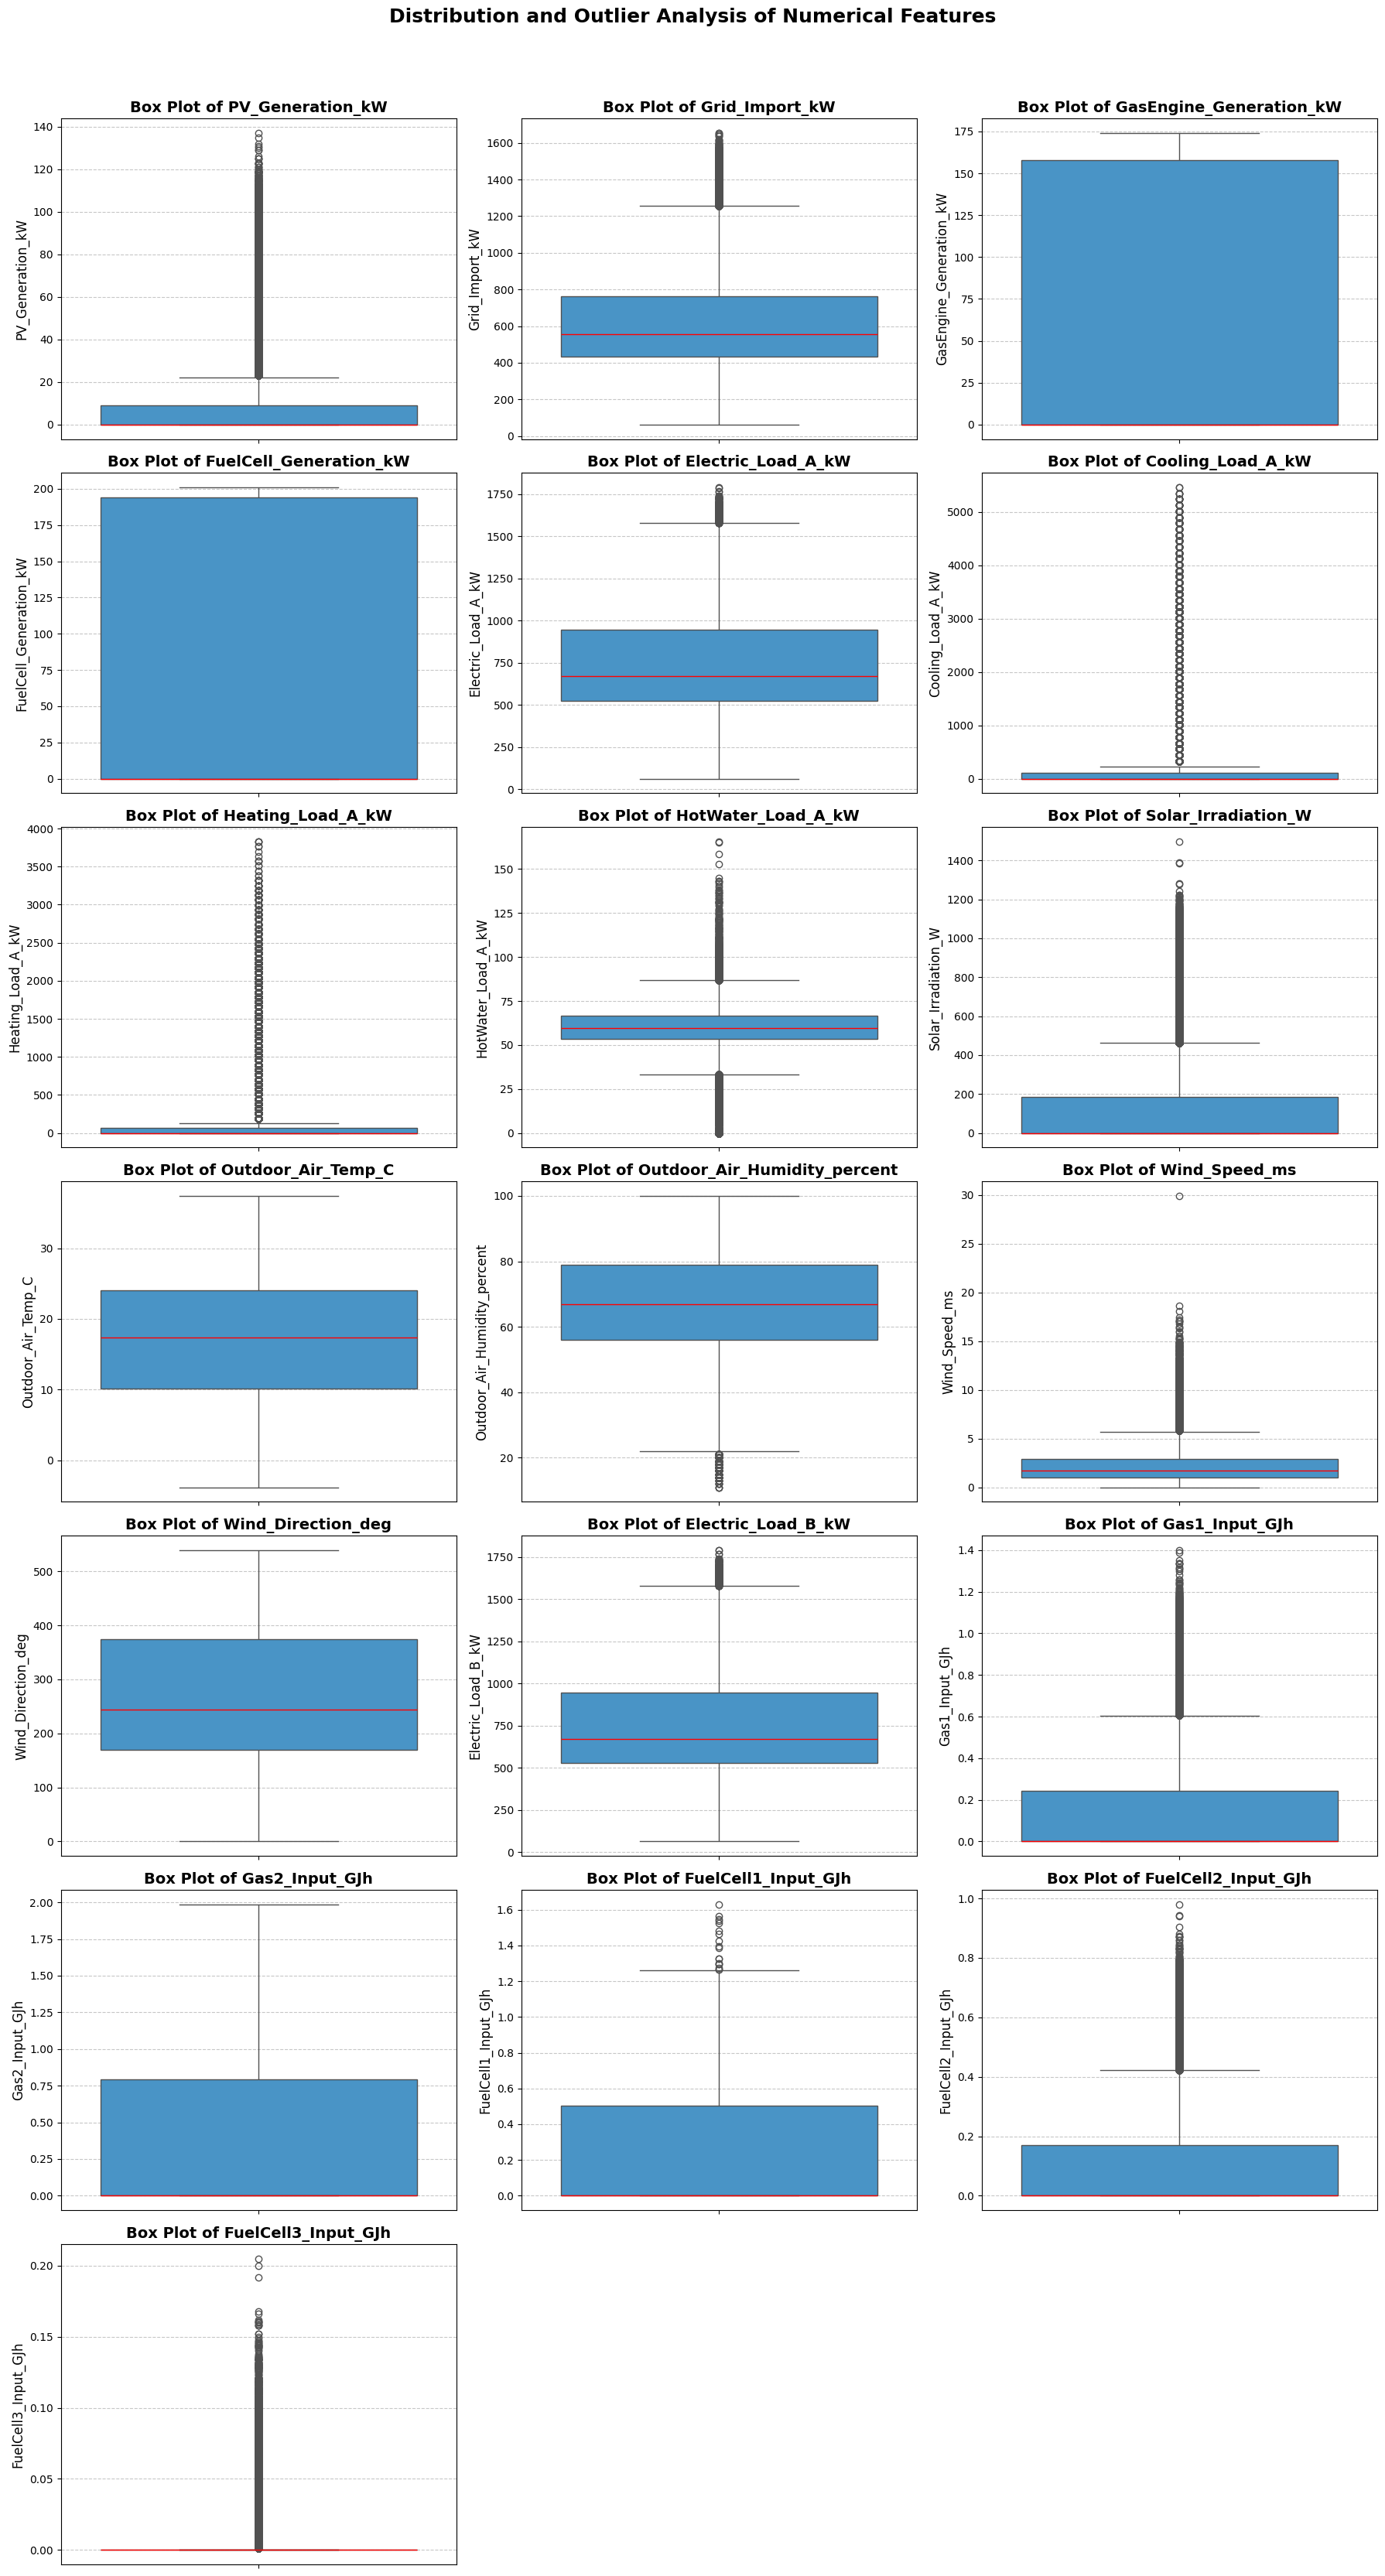

In [7]:
# Function to generate box plots for numerical columns
def generate_box_plots(df):
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

    if not numerical_cols:
        print("No numerical columns found in the dataset to plot.")
        return

    print(f"Found {len(numerical_cols)} numerical columns: {numerical_cols}")

    num_plots = len(numerical_cols)
    
    cols_per_row = 3
    rows = int(np.ceil(num_plots / cols_per_row))

    fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 6, rows * 5))
    
    if rows > 1 or cols_per_row > 1:
        axes = axes.flatten()
    else: 
        axes = [axes]


    for i, col in enumerate(numerical_cols):
        ax = axes[i] 
        
        sns.boxplot(y=df[col], ax=ax, color='#3498db', medianprops={'color':'red'})
        
        ax.set_title(f'Box Plot of {col}', fontsize=14, fontweight='bold')
        ax.set_ylabel(col, fontsize=12)
        ax.tick_params(axis='y', labelsize=10)
        
        ax.set_xlabel('')
        
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    fig.suptitle('Distribution and Outlier Analysis of Numerical Features', 
                 fontsize=18, fontweight='heavy', y=0.98)
    
    plt.show()

generate_box_plots(data)

In [8]:
# Function to impute missing values in numerical columns using KNN Imputer
def impute_with_knn(df, n_neighbors=5):
    
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    
    if not numerical_cols:
        print("No numerical columns found for imputation.")
        return df.copy() 

    df_imputed = df.copy()
    
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputed_data = imputer.fit_transform(df_imputed[numerical_cols])    
    df_imputed[numerical_cols] = pd.DataFrame(imputed_data, columns=numerical_cols, index=df_imputed.index)
    
    missing_after = df_imputed[numerical_cols].isnull().sum().sum()
    print(f"Missing values in numerical columns after imputation: {missing_after}")

    return df_imputed

imputed_data = impute_with_knn(data, n_neighbors=5)
print(imputed_data.isnull().sum())

Missing values in numerical columns after imputation: 0
Date                            0
PV_Generation_kW                0
Grid_Import_kW                  0
GasEngine_Generation_kW         0
FuelCell_Generation_kW          0
Electric_Load_A_kW              0
Cooling_Load_A_kW               0
Heating_Load_A_kW               0
HotWater_Load_A_kW              0
Solar_Irradiation_W             0
Outdoor_Air_Temp_C              0
Outdoor_Air_Humidity_percent    0
Wind_Speed_ms                   0
Wind_Direction_deg              0
Electric_Load_B_kW              0
Gas1_Input_GJh                  0
Gas2_Input_GJh                  0
FuelCell1_Input_GJh             0
FuelCell2_Input_GJh             0
FuelCell3_Input_GJh             0
dtype: int64


In [9]:
# Define target variable and cap outliers
imputed_data['Date'] = pd.to_datetime(imputed_data['Date'], errors='coerce')
imputed_data = imputed_data.dropna(subset=['Date'])
imputed_data = imputed_data.set_index('Date').sort_index()

imputed_data['TARGET_Total_Electric_Load_kW'] = imputed_data['Electric_Load_A_kW'] + imputed_data['Electric_Load_B_kW']
print("Defined 'TARGET_Total_Electric_Load_kW' (A + B).")

Q1 = imputed_data['TARGET_Total_Electric_Load_kW'].quantile(0.01)
Q3 = imputed_data['TARGET_Total_Electric_Load_kW'].quantile(0.99)
IQR = Q3 - Q1
upper_bound = Q3 + 3 * IQR 
lower_bound = max(0, Q1 - 3 * IQR)
imputed_data['TARGET_Total_Electric_Load_kW'] = imputed_data['TARGET_Total_Electric_Load_kW'].clip(lower=lower_bound, upper=upper_bound)
print("Final imputation and target outlier capping complete.")

Defined 'TARGET_Total_Electric_Load_kW' (A + B).
Final imputation and target outlier capping complete.


In [10]:
#Encodes cyclical time features (sin/cos), calculates HDD/CDD, adds lagged load features, and identifies holidays.
imputed_data['Hour'] = imputed_data.index.hour
imputed_data['DayOfWeek'] = imputed_data.index.dayofweek 

imputed_data['Hour_sin'] = np.sin(2 * np.pi * imputed_data['Hour'] / 24)
imputed_data['Hour_cos'] = np.cos(2 * np.pi * imputed_data['Hour'] / 24)
imputed_data['DayOfWeek_sin'] = np.sin(2 * np.pi * imputed_data['DayOfWeek'] / 7)
imputed_data['DayOfWeek_cos'] = np.cos(2 * np.pi * imputed_data['DayOfWeek'] / 7)
imputed_data['Wind_Direction_sin'] = np.sin(2 * np.pi * imputed_data['Wind_Direction_deg'] / 360)
imputed_data['Wind_Direction_cos'] = np.cos(2 * np.pi * imputed_data['Wind_Direction_deg'] / 360)

BASE_TEMP = 18.0

imputed_data['HDD'] = (BASE_TEMP - imputed_data['Outdoor_Air_Temp_C']).clip(lower=0)
imputed_data['CDD'] = (imputed_data['Outdoor_Air_Temp_C'] - BASE_TEMP).clip(lower=0)

imputed_data['Temp_Stress_x_Hour'] = abs(imputed_data['Outdoor_Air_Temp_C'] - BASE_TEMP) * imputed_data['Hour']
imputed_data['Is_Solar_Active'] = (imputed_data['Solar_Irradiation_W'] > 50).astype(int)

imputed_data['Lag_24h_Load'] = imputed_data['TARGET_Total_Electric_Load_kW'].shift(24) 
imputed_data['EWMA_24h_Load'] = imputed_data['TARGET_Total_Electric_Load_kW'].ewm(span=24).mean().shift(1)

us_holidays = holidays.US(years=imputed_data.index.year.unique())
imputed_data['Is_Holiday'] = imputed_data.index.to_series().apply(lambda date: date in us_holidays).astype(int)
imputed_data = imputed_data.drop(columns=['Hour', 'DayOfWeek', 'Wind direction'], errors='ignore')
imputed_data = imputed_data.dropna()
print(imputed_data.head())

                     PV_Generation_kW  Grid_Import_kW  \
Date                                                    
2001-06-02 00:00:00               0.0           220.0   
2001-06-02 01:00:00               0.0           193.0   
2001-06-02 02:00:00               0.0           189.0   
2001-06-02 03:00:00               0.0           182.0   
2001-06-02 04:00:00               0.0           184.0   

                     GasEngine_Generation_kW  FuelCell_Generation_kW  \
Date                                                                   
2001-06-02 00:00:00                      0.0                   194.0   
2001-06-02 01:00:00                      0.0                   174.0   
2001-06-02 02:00:00                      0.0                   162.0   
2001-06-02 03:00:00                      0.0                   151.0   
2001-06-02 04:00:00                      0.0                   151.0   

                     Electric_Load_A_kW  Cooling_Load_A_kW  Heating_Load_A_kW  \
Date          

In [11]:
# Final overview of the processed data
imputed_data.describe()

,PV_Generation_kW,Grid_Import_kW,GasEngine_Generation_kW,FuelCell_Generation_kW,Electric_Load_A_kW,Cooling_Load_A_kW,Heating_Load_A_kW,HotWater_Load_A_kW,Solar_Irradiation_W,Outdoor_Air_Temp_C,...,DayOfWeek_cos,Wind_Direction_sin,Wind_Direction_cos,HDD,CDD,Temp_Stress_x_Hour,Is_Solar_Active,Lag_24h_Load,EWMA_24h_Load,Is_Holiday
count,187728.000000,187728.000000,187728.000000,187728.000000,187728.000000,187728.000000,187728.000000,187728.000000,187728.000000,187728.000000,...,187728.000000,187728.000000,187728.000000,187728.000000,187728.000000,187728.000000,187728.000000,187728.000000,187728.000000,187728.000000
mean,10.164205,611.286209,48.704041,81.303525,751.452228,207.383124,158.057894,53.382034,145.015788,17.079189,...,0.000179,0.109008,-0.077165,3.961451,3.040639,79.992149,0.366248,1502.904296,1502.906696,0.030811
std,21.370533,260.600764,73.457763,89.210968,282.414956,573.633412,401.979296,21.263118,250.325491,8.106602,...,0.707103,0.709441,0.691998,4.963176,4.122265,72.282607,0.481780,564.825597,333.210623,0.172805
min,0.000000,63.000000,0.000000,0.000000,63.000000,0.000000,0.000000,0.000000,0.000000,-3.800000,...,-0.900969,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,126.000000,584.835317,0.000000
25%,0.000000,434.000000,0.000000,0.000000,527.000000,0.000000,0.000000,50.281800,0.000000,10.200000,...,-0.900969,-0.559193,-0.798636,0.000000,0.000000,20.700000,0.000000,1054.000000,1262.328111,0.000000
50%,0.000000,554.000000,0.000000,0.000000,671.000000,0.000000,0.000000,58.615800,0.039000,17.400000,...,-0.222521,0.121869,-0.034899,0.600000,0.000000,60.500000,0.000000,1342.000000,1482.504230,0.000000
75%,9.000000,761.250000,158.000000,194.000000,947.000000,0.000000,63.793400,65.838600,187.000000,24.000000,...,0.623490,0.857167,0.529919,7.800000,6.000000,121.000000,1.000000,1894.000000,1724.081787,0.000000
max,137.000000,1653.000000,174.000000,201.000000,1790.000000,5459.825000,3827.604000,165.568800,1496.000000,37.400000,...,1.000000,1.000000,1.000000,21.800000,19.400000,485.300000,1.000000,3580.000000,2654.796565,1.000000


In [12]:
# Save the final feature-engineered data
imputed_data.to_csv('../Data_Output/Feature_Engineered_Data.csv', index=True)

In [13]:
# Load the final feature-engineered data
df = pd.read_csv("../Data_Output/Feature_Engineered_Data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

TARGET = "TARGET_Total_Electric_Load_kW"

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (187728, 34)


,Date,PV_Generation_kW,Grid_Import_kW,GasEngine_Generation_kW,FuelCell_Generation_kW,Electric_Load_A_kW,Cooling_Load_A_kW,Heating_Load_A_kW,HotWater_Load_A_kW,Solar_Irradiation_W,...,DayOfWeek_cos,Wind_Direction_sin,Wind_Direction_cos,HDD,CDD,Temp_Stress_x_Hour,Is_Solar_Active,Lag_24h_Load,EWMA_24h_Load,Is_Holiday
0,2001-06-02 00:00:00,0.0,220.0,0.0,194.0,414.0,0.0,0.0,20.0,0.0,...,-0.222521,-0.669131,-0.743145,0.0,1.5,0.0,0,886.0,1255.499994,0
1,2001-06-02 01:00:00,0.0,193.0,0.0,174.0,367.0,0.0,0.0,21.0,0.0,...,-0.222521,-0.484810,-0.874620,0.0,0.6,0.6,0,896.0,1216.442657,0
2,2001-06-02 02:00:00,0.0,189.0,0.0,162.0,351.0,0.0,0.0,21.0,0.0,...,-0.222521,-0.515038,-0.857167,0.0,0.4,0.8,0,834.0,1172.860823,0
3,2001-06-02 03:00:00,0.0,182.0,0.0,151.0,333.0,0.0,0.0,22.0,0.0,...,-0.222521,-0.469472,-0.882948,0.0,0.4,1.2,0,852.0,1130.760383,0
4,2001-06-02 04:00:00,0.0,184.0,0.0,151.0,335.0,0.0,0.0,22.0,0.0,...,-0.222521,-0.422618,-0.906308,0.0,0.5,2.0,0,858.0,1089.592848,0


In [14]:
# Check for any remaining missing values
df.isnull().sum()

Date                             0
PV_Generation_kW                 0
Grid_Import_kW                   0
GasEngine_Generation_kW          0
FuelCell_Generation_kW           0
Electric_Load_A_kW               0
Cooling_Load_A_kW                0
Heating_Load_A_kW                0
HotWater_Load_A_kW               0
Solar_Irradiation_W              0
Outdoor_Air_Temp_C               0
Outdoor_Air_Humidity_percent     0
Wind_Speed_ms                    0
Wind_Direction_deg               0
Electric_Load_B_kW               0
Gas1_Input_GJh                   0
Gas2_Input_GJh                   0
FuelCell1_Input_GJh              0
FuelCell2_Input_GJh              0
FuelCell3_Input_GJh              0
TARGET_Total_Electric_Load_kW    0
Hour_sin                         0
Hour_cos                         0
DayOfWeek_sin                    0
DayOfWeek_cos                    0
Wind_Direction_sin               0
Wind_Direction_cos               0
HDD                              0
CDD                 

In [15]:
df.columns

Index(['Date', 'PV_Generation_kW', 'Grid_Import_kW', 'GasEngine_Generation_kW',
       'FuelCell_Generation_kW', 'Electric_Load_A_kW', 'Cooling_Load_A_kW',
       'Heating_Load_A_kW', 'HotWater_Load_A_kW', 'Solar_Irradiation_W',
       'Outdoor_Air_Temp_C', 'Outdoor_Air_Humidity_percent', 'Wind_Speed_ms',
       'Wind_Direction_deg', 'Electric_Load_B_kW', 'Gas1_Input_GJh',
       'Gas2_Input_GJh', 'FuelCell1_Input_GJh', 'FuelCell2_Input_GJh',
       'FuelCell3_Input_GJh', 'TARGET_Total_Electric_Load_kW', 'Hour_sin',
       'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Wind_Direction_sin',
       'Wind_Direction_cos', 'HDD', 'CDD', 'Temp_Stress_x_Hour',
       'Is_Solar_Active', 'Lag_24h_Load', 'EWMA_24h_Load', 'Is_Holiday'],
      dtype='object')

In [16]:
df.dtypes

Date                             datetime64[ns]
PV_Generation_kW                        float64
Grid_Import_kW                          float64
GasEngine_Generation_kW                 float64
FuelCell_Generation_kW                  float64
Electric_Load_A_kW                      float64
Cooling_Load_A_kW                       float64
Heating_Load_A_kW                       float64
HotWater_Load_A_kW                      float64
Solar_Irradiation_W                     float64
Outdoor_Air_Temp_C                      float64
Outdoor_Air_Humidity_percent            float64
Wind_Speed_ms                           float64
Wind_Direction_deg                      float64
Electric_Load_B_kW                      float64
Gas1_Input_GJh                          float64
Gas2_Input_GJh                          float64
FuelCell1_Input_GJh                     float64
FuelCell2_Input_GJh                     float64
FuelCell3_Input_GJh                     float64
TARGET_Total_Electric_Load_kW           

In [17]:
#  overview of the processed data
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,187728,2012-02-15 23:30:00,2001-06-02 00:00:00,2006-10-09 11:45:00,2012-02-15 23:30:00,2017-06-24 11:15:00,2022-10-31 23:00:00,NaN
PV_Generation_kW,187728.0,10.164205,0.0,0.0,0.0,9.0,137.0,21.370533
Grid_Import_kW,187728.0,611.286209,63.0,434.0,554.0,761.25,1653.0,260.600764
GasEngine_Generation_kW,187728.0,48.704041,0.0,0.0,0.0,158.0,174.0,73.457763
FuelCell_Generation_kW,187728.0,81.303525,0.0,0.0,0.0,194.0,201.0,89.210968
Electric_Load_A_kW,187728.0,751.452228,63.0,527.0,671.0,947.0,1790.0,282.414956
Cooling_Load_A_kW,187728.0,207.383124,0.0,0.0,0.0,0.0,5459.825,573.633412
Heating_Load_A_kW,187728.0,158.057894,0.0,0.0,0.0,63.7934,3827.604,401.979296
HotWater_Load_A_kW,187728.0,53.382034,0.0,50.2818,58.6158,65.8386,165.5688,21.263118
Solar_Irradiation_W,187728.0,145.015788,0.0,0.0,0.039,187.0,1496.0,250.325491


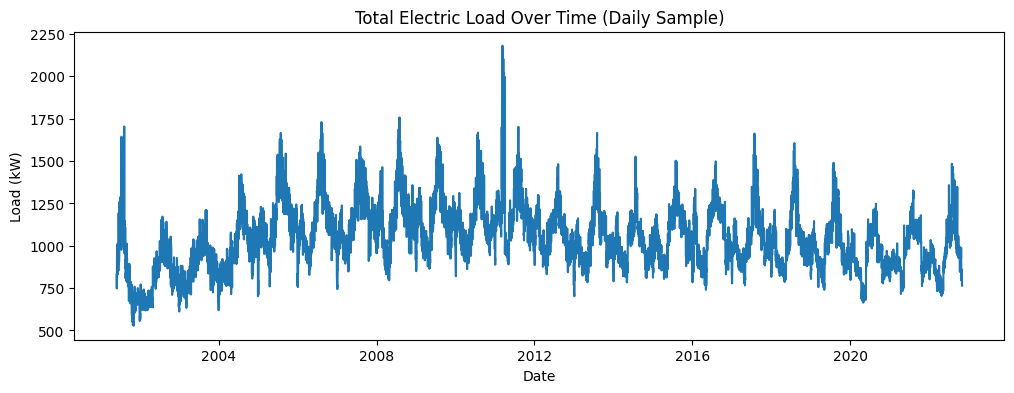

In [18]:
# Target over time (daily sample for speed)
plt.figure(figsize=(12,4))
plt.plot(df["Date"].iloc[::24], df[TARGET].iloc[::24])
plt.title("Total Electric Load Over Time (Daily Sample)")
plt.xlabel("Date")
plt.ylabel("Load (kW)")
plt.show()

The daily-sampled electric load graph shows clear yearly seasonal patterns, with demand rising and falling consistently across years. There are noticeable peaks likely caused by extreme weather or operational spikes, while the overall trend remains relatively stable with slight variations over time. Daily sampling smooths hourly noise, making long-term cycles easy to observe. These recurring seasonal patterns and occasional sharp peaks indicate that the energy system has strong nonlinear behavior.

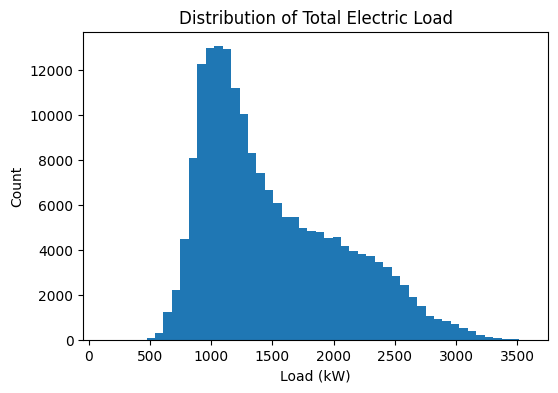

In [19]:
# Total Electric Load distribution
plt.figure(figsize=(6,4))
plt.hist(df[TARGET].dropna(), bins=50)
plt.title("Distribution of Total Electric Load")
plt.xlabel("Load (kW)")
plt.ylabel("Count")
plt.show()


The distribution of total electric load is right-skewed, most energy consumption values fall between 900–1500 kW, where the grid operates most of the time. The frequency sharply drops as load increases, and only a small number of high-demand events exceed 2500–3000 kW. This pattern is typical of smart-grid systems where daily operations fluctuate within a stable mid-range, while extreme peaks occur occasionally due to seasonal changes, weather effects, or sudden demand spikes

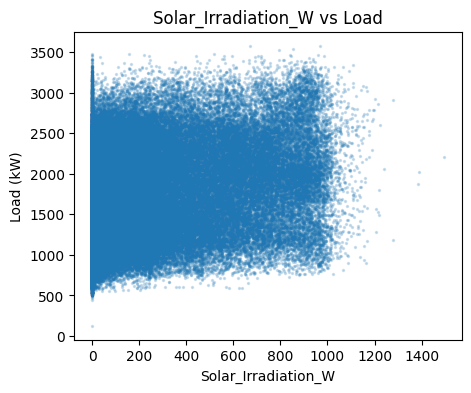

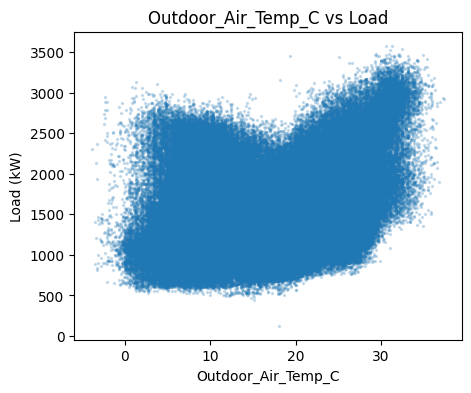

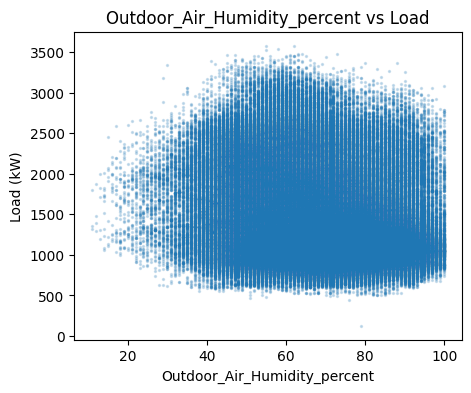

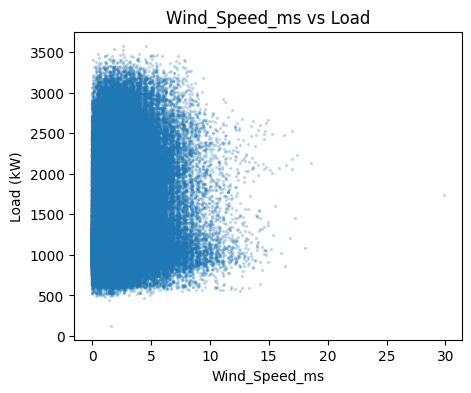

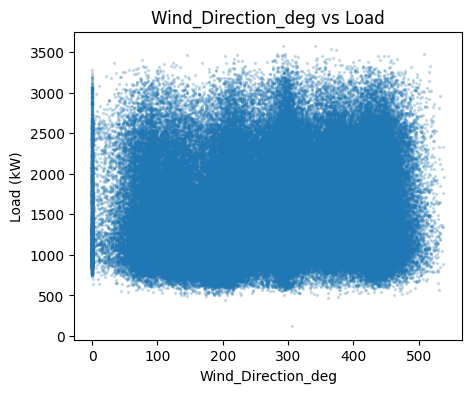

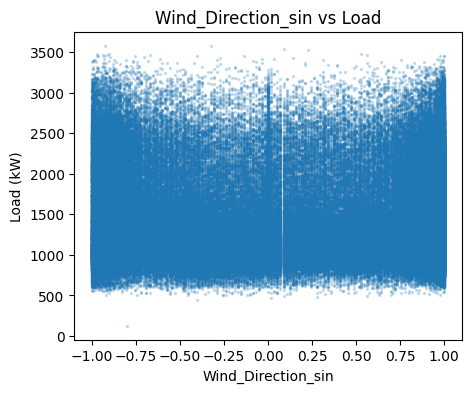

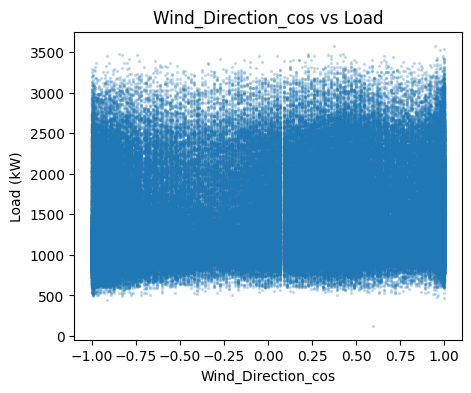

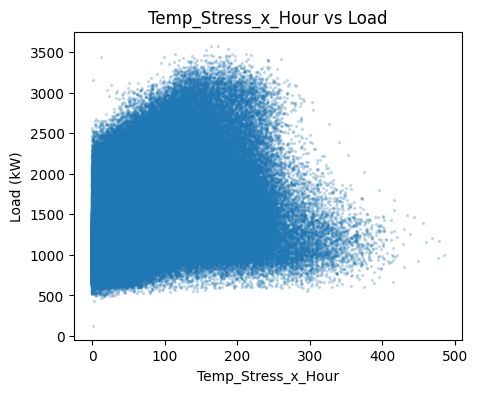

In [20]:
# Weather vs Load quick EDA
weather_cols = [c for c in df.columns if any(k in c.lower() for k in ["temp","humidity","wind","irradiation"])]
for c in weather_cols:
    plt.figure(figsize=(5,4))
    plt.scatter(df[c], df[TARGET], s=2, alpha=0.2)
    plt.title(f"{c} vs Load")
    plt.xlabel(c)
    plt.ylabel("Load (kW)")
    plt.show()

## Data Leakage Prevention
We will remove columns that:

- Are components of the target at the same hour,
- Are generation/fuel operational outputs known only after demand happens.
- If these stay in X → R² becomes 1 (cheating). In our previous notebooks, we have got accuracy of almost 1. There is a data leakage issue that we will rectify in this notebook.

In [21]:
# Remove leakage columns
LEAKAGE_COLS = [
    'PV_Generation_kW', 'Grid_Import_kW', 'GasEngine_Generation_kW',
    'FuelCell_Generation_kW', 'Electric_Load_A_kW', 'Electric_Load_B_kW',
    'Cooling_Load_A_kW', 'Heating_Load_A_kW', 'HotWater_Load_A_kW',
    'Gas1_Input_GJh', 'Gas2_Input_GJh', 'FuelCell1_Input_GJh',
    'FuelCell2_Input_GJh', 'FuelCell3_Input_GJh'
]

existing_leaks = [c for c in LEAKAGE_COLS if c in df.columns]
print("Leakage columns found:", existing_leaks)

df_noleak = df.drop(columns=existing_leaks)
print("Shape after dropping leakage:", df_noleak.shape)


Leakage columns found: ['PV_Generation_kW', 'Grid_Import_kW', 'GasEngine_Generation_kW', 'FuelCell_Generation_kW', 'Electric_Load_A_kW', 'Electric_Load_B_kW', 'Cooling_Load_A_kW', 'Heating_Load_A_kW', 'HotWater_Load_A_kW', 'Gas1_Input_GJh', 'Gas2_Input_GJh', 'FuelCell1_Input_GJh', 'FuelCell2_Input_GJh', 'FuelCell3_Input_GJh']
Shape after dropping leakage: (187728, 20)


## Feature Engineering
We will create only safe features that are known at prediction time:

- time features
- cyclical encodings
- HDD/CDD / stress
- lags & rolling windows (past-only)
- trends and rate-of-change features

In [22]:
# The code performs comprehensive time series feature engineering by extracting calendar features, 
# encoding cyclical time and direction variables (sin/cos), deriving Heating/Cooling Degree Days (HDD/CDD) and 
# temperature stress features, adding lagged/rolling/EWMA load features, and computing a custom comfort index.
dfe = df_noleak.copy()

# Time features
dfe["year"] = dfe["Date"].dt.year
dfe["month"] = dfe["Date"].dt.month
dfe["day"] = dfe["Date"].dt.day
dfe["hour"] = dfe["Date"].dt.hour
dfe["weekday"] = dfe["Date"].dt.weekday
dfe["dayofyear"] = dfe["Date"].dt.dayofyear
dfe["is_weekend"] = dfe["weekday"].isin([5,6]).astype(int)

dfe["quarter"] = dfe["Date"].dt.quarter
dfe["week_of_year"] = dfe["Date"].dt.isocalendar().week.astype(int)

def get_season(m):
    if m in [12,1,2]: return 0
    if m in [3,4,5]: return 1
    if m in [6,7,8]: return 2
    return 3

dfe["season"] = dfe["month"].apply(get_season)
dfe["is_peak_hour"] = dfe["hour"].between(17,20).astype(int)

# Cyclical encodings
dfe["Hour_sin"] = np.sin(2*np.pi*dfe["hour"]/24)
dfe["Hour_cos"] = np.cos(2*np.pi*dfe["hour"]/24)
dfe["DayOfWeek_sin"] = np.sin(2*np.pi*dfe["weekday"]/7)
dfe["DayOfWeek_cos"] = np.cos(2*np.pi*dfe["weekday"]/7)

if "Wind_Direction_deg" in dfe.columns:
    dfe["Wind_Direction_sin"] = np.sin(2*np.pi*dfe["Wind_Direction_deg"]/360)
    dfe["Wind_Direction_cos"] = np.cos(2*np.pi*dfe["Wind_Direction_deg"]/360)

# Temperature features
if "Outdoor_Air_Temp_C" in dfe.columns:
    dfe["HDD"] = (18 - dfe["Outdoor_Air_Temp_C"]).clip(lower=0)
    dfe["CDD"] = (dfe["Outdoor_Air_Temp_C"] - 18).clip(lower=0)
    dfe["Temp_x_Hour"] = dfe["Outdoor_Air_Temp_C"] * dfe["hour"]
    dfe["Is_High_Temp"] = (dfe["Outdoor_Air_Temp_C"] > 30).astype(int)
    dfe["Is_Low_Temp"] = (dfe["Outdoor_Air_Temp_C"] < 5).astype(int)

# Solar features
if "Solar_Irradiation_W" in dfe.columns:
    dfe["Is_Solar_Active"] = (dfe["Solar_Irradiation_W"] > 10).astype(int)

# SAFE lags (6h+ to avoid overfitting)
dfe["Lag_6h_Load"]  = dfe[TARGET].shift(6)
dfe["Lag_12h_Load"] = dfe[TARGET].shift(12)
dfe["Lag_24h_Load"] = dfe[TARGET].shift(24)
dfe["Lag_48h_Load"] = dfe[TARGET].shift(48)

# Rolling features (properly shifted)
dfe["Rolling_Mean_12h"] = dfe[TARGET].shift(1).rolling(12).mean()
dfe["Rolling_Mean_24h"] = dfe[TARGET].shift(1).rolling(24).mean()
dfe["Rolling_Std_24h"]  = dfe[TARGET].shift(1).rolling(24).std()
dfe["EWMA_24h_Load"]    = dfe[TARGET].shift(1).ewm(span=24, adjust=False).mean()

# Comfort index
if all(c in dfe.columns for c in ["Outdoor_Air_Temp_C","Outdoor_Air_Humidity_percent","Wind_Speed_ms"]):
    dfe["Comfort_Index"] = (dfe["Outdoor_Air_Temp_C"] - 22)**2 \
                           + 0.5*dfe["Outdoor_Air_Humidity_percent"] \
                           + 0.2*dfe["Wind_Speed_ms"]

# Drop NaNs 
dfe = dfe.dropna().reset_index(drop=True)
print("Shape after FE:", dfe.shape)

Shape after FE: (187680, 41)


- Time-based features like year, month, day, hour, weekday, dayofyear, quarter, week_of_year, season, and is_weekend capture daily, weekly, and seasonal energy patterns. These help the model understand human activity cycles and long-term seasonal demand shifts.

- Cyclical encodings Hour_sin, Hour_cos, DayOfWeek_sin, and DayOfWeek_cos were added to properly model periodic behavior. This prevents artificial breaks between values like 23 → 0 and improves how the model learns smooth time cycles.

- Weather-derived features such as HDD, CDD, Temp_x_Hour, Is_High_Temp, Is_Low_Temp, and Comfort_Index capture heating/cooling effects. These are critical since temperature, humidity, and wind significantly influence electricity consumption.

- Solar-related features like Is_Solar_Active help identify daytime hours with high solar exposure. These improve performance during bright daylight periods where load behavior changes.

- Lag features Lag_6h_Load, Lag_12h_Load, Lag_24h_Load, and Lag_48h_Load introduce past consumption patterns, which are extremely predictive because energy usage often repeats daily and follows short-term autocorrelation.

- Rolling and smoothed features such as Rolling_Mean_12h, Rolling_Mean_24h, Rolling_Std_24h, and EWMA_24h_Load capture local trends, volatility, and gradual shifts in demand. These help the model detect rising, falling, or unstable load conditions.

- Together, these engineered features provide temporal structure, weather influence, historical memory, and trend awareness

In [23]:
dfe.columns

Index(['Date', 'Solar_Irradiation_W', 'Outdoor_Air_Temp_C',
       'Outdoor_Air_Humidity_percent', 'Wind_Speed_ms', 'Wind_Direction_deg',
       'TARGET_Total_Electric_Load_kW', 'Hour_sin', 'Hour_cos',
       'DayOfWeek_sin', 'DayOfWeek_cos', 'Wind_Direction_sin',
       'Wind_Direction_cos', 'HDD', 'CDD', 'Temp_Stress_x_Hour',
       'Is_Solar_Active', 'Lag_24h_Load', 'EWMA_24h_Load', 'Is_Holiday',
       'year', 'month', 'day', 'hour', 'weekday', 'dayofyear', 'is_weekend',
       'quarter', 'week_of_year', 'season', 'is_peak_hour', 'Temp_x_Hour',
       'Is_High_Temp', 'Is_Low_Temp', 'Lag_6h_Load', 'Lag_12h_Load',
       'Lag_48h_Load', 'Rolling_Mean_12h', 'Rolling_Mean_24h',
       'Rolling_Std_24h', 'Comfort_Index'],
      dtype='object')

In [24]:
dfe.shape

(187680, 41)

In [25]:
df.shape

(187728, 34)

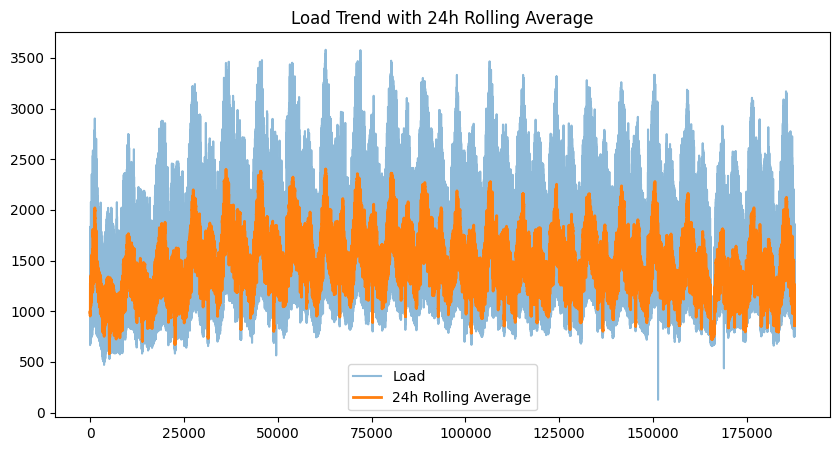

In [26]:
# visualization of load trend with 24h rolling average
plt.figure(figsize=(10,5))
df["Rolling24"] = df["TARGET_Total_Electric_Load_kW"].rolling(24).mean()

plt.plot(df["TARGET_Total_Electric_Load_kW"], label="Load", alpha=0.5)
plt.plot(df["Rolling24"], label="24h Rolling Average", linewidth=2)
plt.title("Load Trend with 24h Rolling Average")
plt.legend()
plt.show()

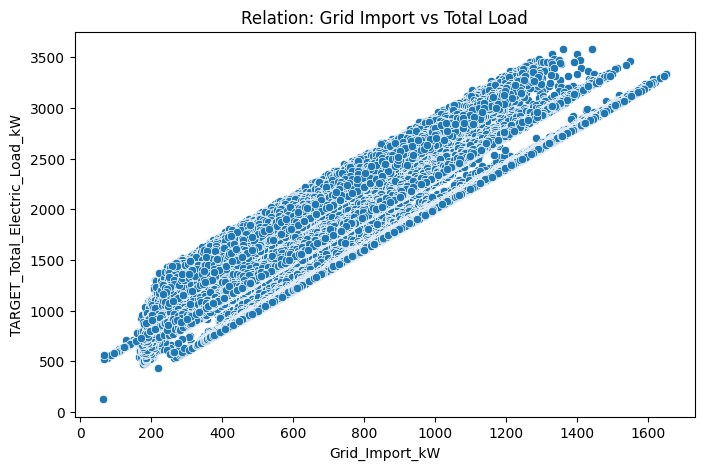

In [27]:
# Scatter plot: Grid Import vs Total Load
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="Grid_Import_kW", y="TARGET_Total_Electric_Load_kW")
plt.title("Relation: Grid Import vs Total Load")
plt.show()

The scatter plot shows a strong positive linear relationship between Grid_Import_kW and Total Electric Load, meaning that as the total demand increases, the grid consistently supplies more power to meet the load. The tight clustering and parallel bands indicate operational patterns or load segments, likely reflecting different building combinations or equipment schedules.

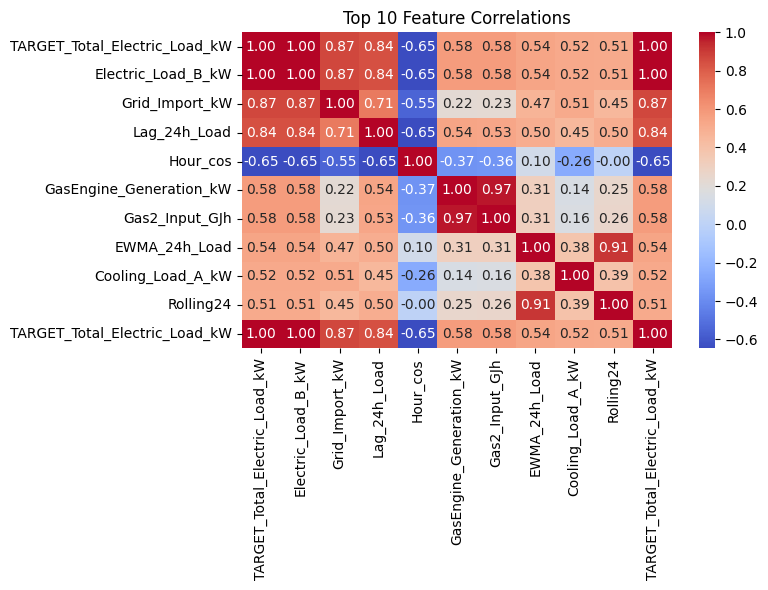

In [28]:
# Compute top 20 correlated features

corr = df.corr(numeric_only=True)
top20 = corr["TARGET_Total_Electric_Load_kW"].abs().sort_values(ascending=False)[1:11].index

plt.figure(figsize=(8,6))
sns.heatmap(df[top20.tolist() + ["TARGET_Total_Electric_Load_kW"]].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Top 10 Feature Correlations")
plt.tight_layout()
plt.show()


In [29]:
# Compute and display correlations to target
corr = dfe.drop(columns=["Date"]).corr(numeric_only=True)[TARGET].sort_values(ascending=False)
print("Top correlations to target:")
print(corr.head(25))

Top correlations to target:
TARGET_Total_Electric_Load_kW    1.000000
Lag_24h_Load                     0.842302
Lag_48h_Load                     0.704413
EWMA_24h_Load                    0.541758
Rolling_Mean_24h                 0.502502
Is_Solar_Active                  0.464932
Rolling_Std_24h                  0.442639
Solar_Irradiation_W              0.423581
CDD                              0.422645
Temp_x_Hour                      0.413645
Rolling_Mean_12h                 0.349159
Outdoor_Air_Temp_C               0.339798
Temp_Stress_x_Hour               0.339731
Is_High_Temp                     0.336616
Lag_6h_Load                      0.306679
hour                             0.301415
DayOfWeek_sin                    0.248752
Wind_Direction_cos               0.234021
Wind_Direction_deg               0.172899
Wind_Speed_ms                    0.129868
is_peak_hour                     0.108544
season                           0.101869
quarter                          0.078898
week_o

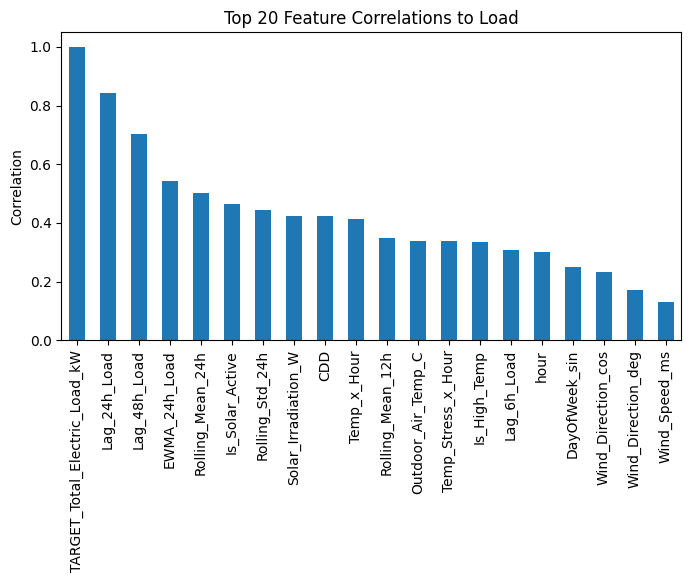

In [30]:
# Plot top 20 correlations to target
plt.figure(figsize=(8,4))
corr.head(20).plot(kind="bar")
plt.title("Top 20 Feature Correlations to Load")
plt.ylabel("Correlation")
plt.show()


This bar chart shows which engineered features have the strongest linear relationships with the total electric load. As expected, lag-based features such as Lag_24h_Load and Lag_48h_Load show very high correlation because electricity demand follows strong daily patterns. Rolling features like EWMA_24h_Load and Rolling_Mean_24h also rank highly, capturing smoothed trends that help stabilize noisy load fluctuations.

Weather-driven variables such as CDD, Outdoor_Air_Temp_C, and Temp_x_Hour demonstrate moderate correlations, reflecting how temperature influences HVAC demand. Solar-related features and wind-related variables show smaller correlations but still contribute valuable environmental context.

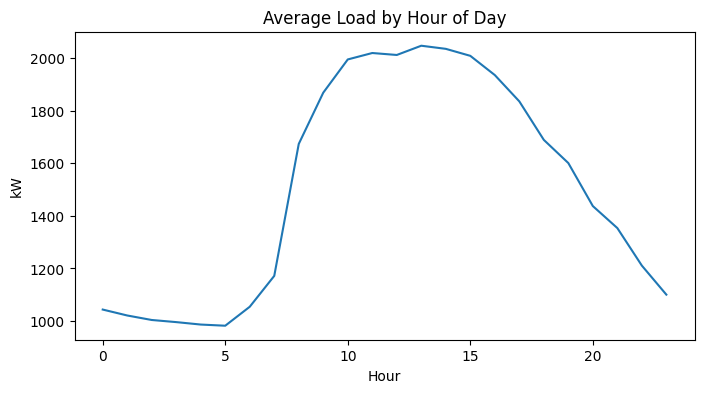

In [31]:
# Average Load by Hour of Day
by_hour = dfe.groupby("hour")[TARGET].mean()
plt.figure(figsize=(8,4))
plt.plot(by_hour.index, by_hour.values)
plt.title("Average Load by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("kW")
plt.show()

The graph shows a strong daily consumption pattern where electricity load stays low during early morning hours (1–6 AM), then rapidly increases after 7 AM, peaking between 11 AM and 3 PM when building activity is highest. After the afternoon peak, the load gradually decreases through the evening.

## Modeling Setup 
Features = everything except Date and Target. Time-ordered split.

In [32]:
# MODELING SETUP - 

# Remove Date + Target only 
feature_cols = [c for c in dfe.columns if c not in ["Date", TARGET]]

X = dfe[feature_cols]
y = dfe[TARGET]

# Verify no NaN values (should be 0 since we dropped in cell 13)
print(f"NaN in X: {X.isna().sum().sum()}")
print(f"NaN in y: {y.isna().sum()}")

# Time-ordered split (NO shuffle!)
split_idx = int(len(dfe) * 0.80)

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

print("\nTrain Shape :", X_train.shape)
print("Test Shape  :", X_test.shape)
print("✓ Data is clean - ready for modeling!")

NaN in X: 0
NaN in y: 0

Train Shape : (150144, 39)
Test Shape  : (37536, 39)
✓ Data is clean - ready for modeling!


## Baseline Model (24-Hour Lag Forecast)
For this project, we used a 24-hour lag (Lag_24h_Load) as our baseline model. This means the model simply predicts that today’s load will be the same as the load at the same hour yesterday.

This is a very common and meaningful baseline for energy forecasting because electricity demand follows strong daily patterns—people behave similarly at the same hour every day (work hours, evening peaks, night lows). So a 24-hour lag gives a fair, realistic benchmark to compare all ML models.


BASELINE MODEL PERFORMANCE (24-hour Lag)
MAE  : 170.72 kW
RMSE : 325.38 kW
R²   : 0.6318


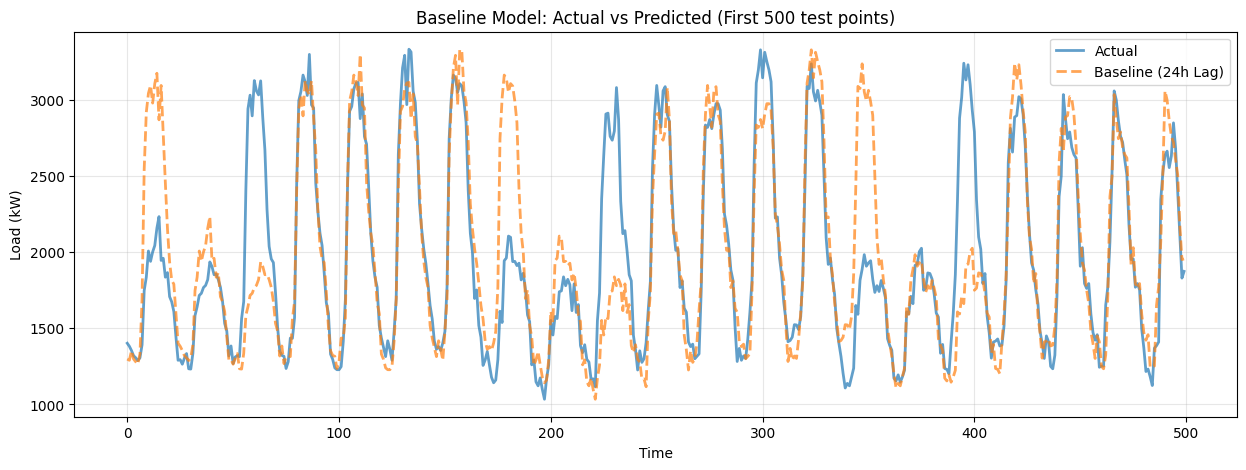

In [33]:
# BASELINE MODEL - Naive Forecast (24-hour lag)

baseline_pred = X_test["Lag_24h_Load"].values

baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))  # Fixed
baseline_r2 = r2_score(y_test, baseline_pred)

print("\n" + "="*60)
print("BASELINE MODEL PERFORMANCE (24-hour Lag)")
print("="*60)
print(f"MAE  : {baseline_mae:.2f} kW")
print(f"RMSE : {baseline_rmse:.2f} kW")
print(f"R²   : {baseline_r2:.4f}")
print("="*60)

# Visualize predictions
plt.figure(figsize=(15, 5))
plt.plot(y_test.values[:500], label='Actual', alpha=0.7, linewidth=2)
plt.plot(baseline_pred[:500], label='Baseline (24h Lag)', alpha=0.7, linewidth=2, linestyle='--')
plt.title('Baseline Model: Actual vs Predicted (First 500 test points)')
plt.xlabel('Time')
plt.ylabel('Load (kW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The baseline model follows the overall daily load pattern reasonably well, especially during regular weekdays where human activity is consistent. The orange dashed line tracks the general wave shape of the blue actual load curve, showing that yesterday’s same-hour load is often a good starting estimate. However, the baseline misses sharp peaks and sudden drops, especially during high-demand hours. These deviations indicate that the energy load is influenced by additional factors such as temperature, time-of-day patterns, rolling averages, and building-level loads which cannot be captured by a simple lag.

In [34]:
# Check total number of NaNs per column
print("Missing values per column:")
print(df.isna().sum())

# Check percentage of missing values per column
print("\nPercentage of missing values:")
print((df.isna().mean() * 100).round(2))

# check if any row has NaNs
print("\nAny rows with NaNs:", df.isna().any(axis=1).sum())

Missing values per column:
Date                              0
PV_Generation_kW                  0
Grid_Import_kW                    0
GasEngine_Generation_kW           0
FuelCell_Generation_kW            0
Electric_Load_A_kW                0
Cooling_Load_A_kW                 0
Heating_Load_A_kW                 0
HotWater_Load_A_kW                0
Solar_Irradiation_W               0
Outdoor_Air_Temp_C                0
Outdoor_Air_Humidity_percent      0
Wind_Speed_ms                     0
Wind_Direction_deg                0
Electric_Load_B_kW                0
Gas1_Input_GJh                    0
Gas2_Input_GJh                    0
FuelCell1_Input_GJh               0
FuelCell2_Input_GJh               0
FuelCell3_Input_GJh               0
TARGET_Total_Electric_Load_kW     0
Hour_sin                          0
Hour_cos                          0
DayOfWeek_sin                     0
DayOfWeek_cos                     0
Wind_Direction_sin                0
Wind_Direction_cos                0
H

Linear Regression was included in our modeling workflow as a baseline model to establish a foundational performance benchmark for energy demand forecasting. Although the energy load exhibits complex, nonlinear patterns influenced by temperature, weather, occupancy cycles, and operational behaviors, Linear Regression still serves an essential role in validating the predictive value of engineered features and ensuring that more advanced models truly add value.

In [35]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

# Metrics
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

print("\n" + "="*60)
print("LINEAR REGRESSION PERFORMANCE")
print("="*60)
print(f"MAE  : {lr_mae:.2f} kW")
print(f"RMSE : {lr_rmse:.2f} kW")
print(f"R²   : {lr_r2:.4f}")
print("="*60)


LINEAR REGRESSION PERFORMANCE
MAE  : 144.26 kW
RMSE : 187.07 kW
R²   : 0.8783


The Linear Regression model shows moderate performance, with an MAE of 144.26 kW and an RMSE of 187.07 kW, indicating a noticeable average deviation between actual and predicted energy load values. Although the R² score of 0.8783 suggests that the model explains a large portion of the variance in the target variable, the relatively high errors reveal that Linear Regression struggles to capture the nonlinear patterns and fluctuations in energy consumption.

In [36]:
# Create a dataframe with actual, predicted, and error
pred_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": lr_pred,
})

# Compute error
pred_df["Error"] = pred_df["Actual"] - pred_df["Predicted"]

# Show the first 10 rows
print(pred_df.head(10))

   Actual    Predicted       Error
0  1402.0  1300.426372  101.573628
1  1382.0  1252.013231  129.986769
2  1354.0  1229.422530  124.577470
3  1320.0  1263.824163   56.175837
4  1306.0  1139.623443  166.376557
5  1288.0  1241.564654   46.435346
6  1306.0  1383.114075  -77.114075
7  1392.0  1557.832025 -165.832025
8  1748.0  1911.057370 -163.057370
9  1836.0  2138.400209 -302.400209


We will now use Ridge regression for forecasting workflow to improve upon the limitations of simple Linear Regression and to provide a stronger, more stable benchmark before moving to advanced tree-based and neural models. While the energy demand patterns are inherently nonlinear and influenced by complex weather–time interactions, Ridge Regression offers several advantages that make it valuable in this stage of the modeling process.

In [37]:
# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

# Metrics
ridge_mae = mean_absolute_error(y_test, ridge_pred)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
ridge_r2 = r2_score(y_test, ridge_pred)

print("\n" + "="*60)
print("RIDGE REGRESSION PERFORMANCE")
print("="*60)
print(f"MAE  : {ridge_mae:.2f} kW")
print(f"RMSE : {ridge_rmse:.2f} kW")
print(f"R²   : {ridge_r2:.4f}")
print("="*60)


RIDGE REGRESSION PERFORMANCE
MAE  : 144.25 kW
RMSE : 187.07 kW
R²   : 0.8783


Ridge Regression shows almost identical performance to Linear Regression, with an MAE of 144.25 kW, an RMSE of 187.07 kW, and an R² score of 0.8783. This means the model captures general load patterns reasonably well but struggles with nonlinear fluctuations in energy consumption.

In [38]:
# Create a DataFrame with Actual, Predicted, and Error
pred_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": ridge_pred,
})

# Error column
pred_df["Error"] = pred_df["Actual"] - pred_df["Predicted"]

# Show first 10 rows
print(pred_df.head(10))

# Summary statistics
print("\nError Summary:")
print(pred_df["Error"].describe())

   Actual    Predicted       Error
0  1402.0  1300.470651  101.529349
1  1382.0  1252.053632  129.946368
2  1354.0  1229.457455  124.542545
3  1320.0  1263.863908   56.136092
4  1306.0  1139.649629  166.350371
5  1288.0  1241.600921   46.399079
6  1306.0  1383.159774  -77.159774
7  1392.0  1557.877995 -165.877995
8  1748.0  1911.088471 -163.088471
9  1836.0  2138.432604 -302.432604

Error Summary:
count    37536.000000
mean        -8.506923
std        186.874468
min      -1888.236261
25%       -126.368791
50%        -18.811115
75%        106.131242
max        950.163030
Name: Error, dtype: float64


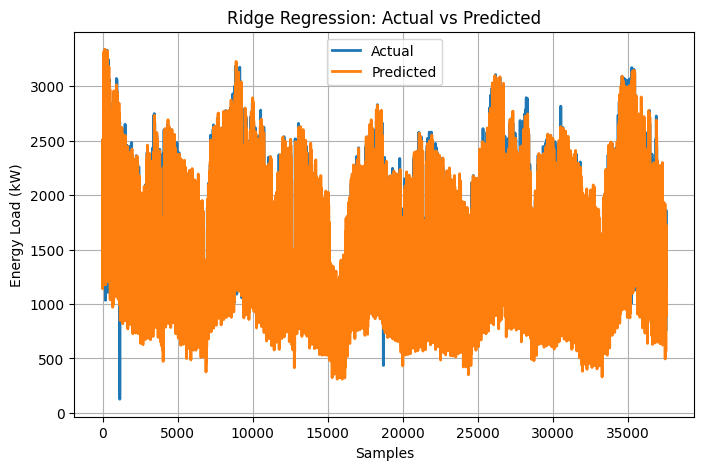

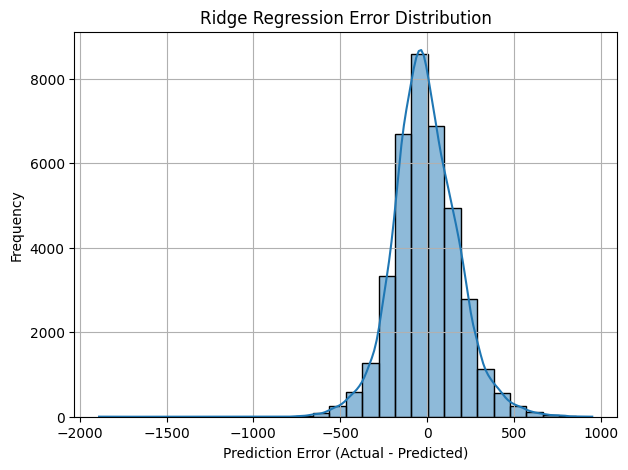

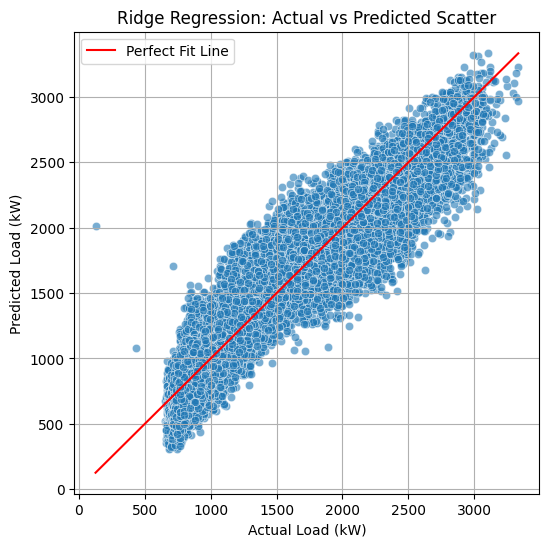

In [39]:
# Actual vs Predicted Plot 
plt.figure(figsize=(8,5))
plt.plot(y_test.values, label="Actual", linewidth=2)
plt.plot(ridge_pred, label="Predicted", linewidth=2)
plt.title("Ridge Regression: Actual vs Predicted")
plt.xlabel("Samples")
plt.ylabel("Energy Load (kW)")
plt.legend()
plt.grid(True)
plt.show()


# Error Distribution 
errors = y_test.values - ridge_pred

plt.figure(figsize=(7,5))
sns.histplot(errors, bins=30, kde=True)
plt.title("Ridge Regression Error Distribution")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# Scatter Plot (Actual vs Predicted)
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test.values, y=ridge_pred, alpha=0.6)
sns.lineplot(x=y_test.values, y=y_test.values, color='red', label="Perfect Fit Line")

plt.title("Ridge Regression: Actual vs Predicted Scatter")
plt.xlabel("Actual Load (kW)")
plt.ylabel("Predicted Load (kW)")
plt.grid(True)
plt.legend()
plt.show()


HistGradientBoosting Regressor was introduced as the next model in our forecasting pipeline because it addresses the limitations of linear models and leverages the non-linear, high-dimensional nature of energy consumption data. After establishing baseline models such as Linear Regression and Ridge Regression, HistGradientBoosting serves as a powerful tree-based learner capable of capturing complex interactions that simpler models cannot.

In [40]:
# HistGradientBoosting Regressor
hgb = HistGradientBoostingRegressor(max_iter=100, random_state=42)
hgb.fit(X_train, y_train)
hgb_pred = hgb.predict(X_test)

# Metrics
hgb_mae = mean_absolute_error(y_test, hgb_pred)
hgb_rmse = np.sqrt(mean_squared_error(y_test, hgb_pred))
hgb_r2 = r2_score(y_test, hgb_pred)

print("\n" + "="*60)
print("HIST GRADIENT BOOSTING PERFORMANCE")
print("="*60)
print(f"MAE   : {hgb_mae:.2f} kW")
print(f"RMSE  : {hgb_rmse:.2f} kW")
print(f"R²    : {hgb_r2:.4f}")
print("="*60)



HIST GRADIENT BOOSTING PERFORMANCE
MAE   : 69.64 kW
RMSE  : 100.97 kW
R²    : 0.9645


The HistGradientBoosting model performs exceptionally well compared to the earlier linear models. With an MAE of 69.58 kW and RMSE of 100.91 kW, its prediction errors are much lower than both Linear and Ridge Regression. The high R² of 0.9646 indicates that the model explains more than 96% of the variance in energy consumption, showing that it captures nonlinear load patterns, time dependencies, and lag effects very effectively.

In [41]:
# Predictions
hgb_pred = hgb.predict(X_test)

# Create DataFrame with Actual, Predicted, and Error
hgb_results = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": hgb_pred,
    "Error": y_test.values - hgb_pred
})

print(hgb_results.head(10))


   Actual    Predicted       Error
0  1402.0  1277.838812  124.161188
1  1382.0  1269.203814  112.796186
2  1354.0  1284.954136   69.045864
3  1320.0  1241.793502   78.206498
4  1306.0  1215.229458   90.770542
5  1288.0  1227.352806   60.647194
6  1306.0  1333.518484  -27.518484
7  1392.0  1554.460452 -162.460452
8  1748.0  1906.750092 -158.750092
9  1836.0  2022.251632 -186.251632


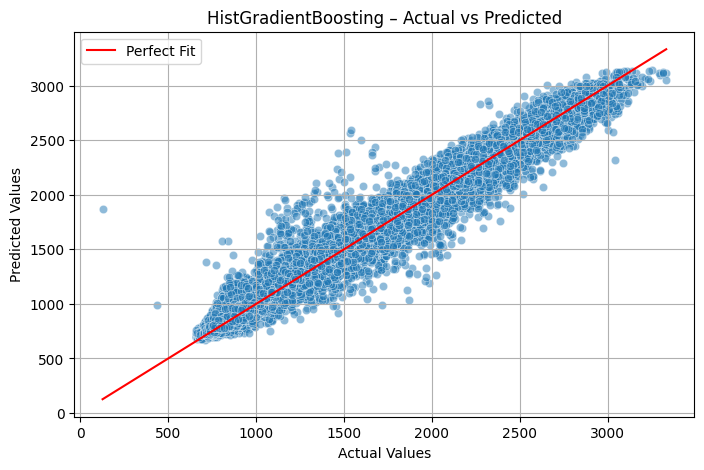

In [42]:
# Function to plot Actual vs Predicted values

def plot_actual_vs_pred(y_true, y_pred, title):
    plt.figure(figsize=(8,5))

    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
    sns.lineplot(x=y_true, y=y_true, color="red", label="Perfect Fit")

    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# CALLING FUNCTION 
plot_actual_vs_pred(y_test, hgb_pred, "HistGradientBoosting – Actual vs Predicted")



In [43]:
# XGBoost Regressor 

# Model
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train
xgb.fit(X_train, y_train)

# Predict
xgb_pred = xgb.predict(X_test)

# Metrics
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)

print("\n" + "="*60)
print("XGBOOST REGRESSION PERFORMANCE")
print("="*60)
print(f"MAE   : {xgb_mae:.2f} kW")
print(f"RMSE  : {xgb_rmse:.2f} kW")
print(f"R²    : {xgb_r2:.4f}")
print("="*60)



XGBOOST REGRESSION PERFORMANCE
MAE   : 66.32 kW
RMSE  : 95.06 kW
R²    : 0.9686


XGBoost delivers excellent forecasting accuracy for energy consumption model, achieving MAE of 66.42 kW, RMSE of 95.45 kW, and a high R² of 0.9683. This means the model captures almost 97% of the variance in energy load, making it one of the strongest performers so far. Both the error values (MAE & RMSE) are significantly lower than linear models and slightly better than HistGradientBoosting


XGBoost Evaluation
MAE  : 66.320
RMSE : 95.064
R²   : 0.9686
MAPE : 4.97%


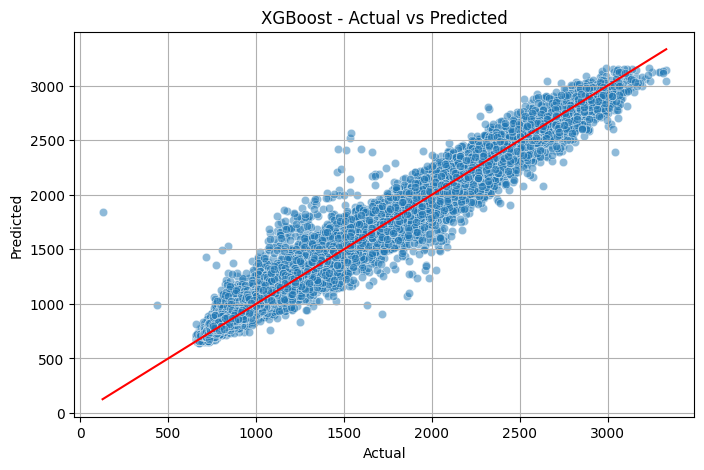

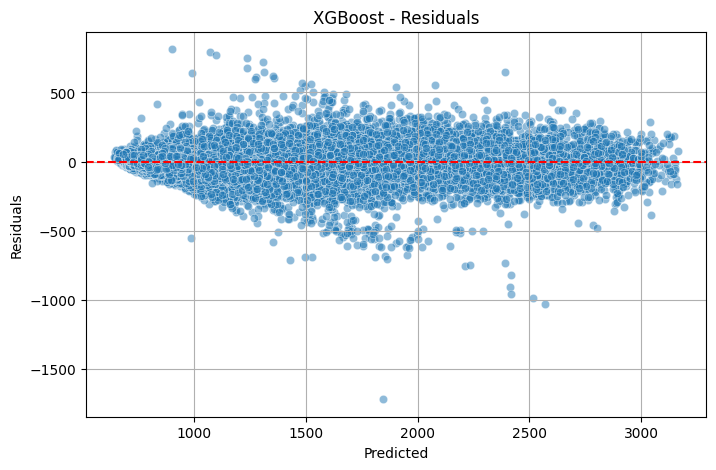

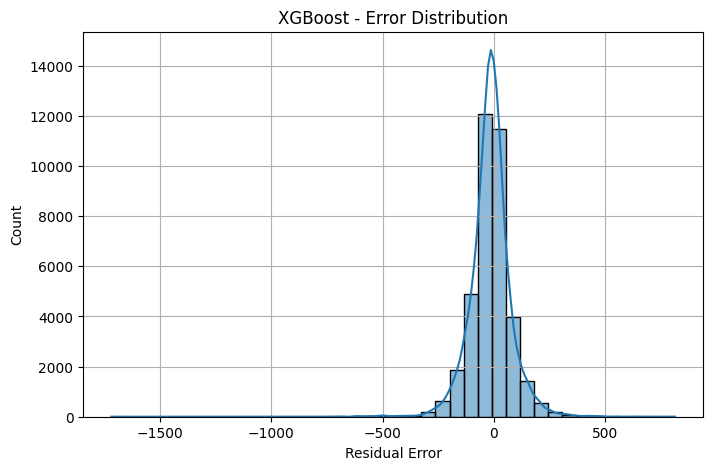

(66.32045567960488, 95.06402795362101, 0.968569837728414, 4.9697601147460615)

In [44]:
# Evaluation function for XGBoost model
def evaluate_xgboost(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    print("\nXGBoost Evaluation")
    print(f"MAE  : {mae:.3f}")
    print(f"RMSE : {rmse:.3f}")
    print(f"R²   : {r2:.4f}")
    print(f"MAPE : {mape:.2f}%")

    # Actual vs Predicted
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
    sns.lineplot(x=y_true, y=y_true, color="red")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("XGBoost - Actual vs Predicted")
    plt.grid(True)
    plt.show()

    # Residuals
    residuals = y_true - y_pred
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("XGBoost - Residuals")
    plt.grid(True)
    plt.show()

    # Error Distribution
    plt.figure(figsize=(8,5))
    sns.histplot(residuals, kde=True, bins=40)
    plt.xlabel("Residual Error")
    plt.title("XGBoost - Error Distribution")
    plt.grid(True)
    plt.show()

    return mae, rmse, r2, mape


# CALL FOR XGBOOST 
evaluate_xgboost(y_test, xgb_pred)


In [45]:
# Create dataframe
results_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": xgb_pred,
    "Error": y_test.values - xgb_pred
})

# Show first rows
results_df.head()


,Actual,Predicted,Error
0,1402.0,1327.397095,74.602905
1,1382.0,1306.472290,75.527710
2,1354.0,1305.037476,48.962524
3,1320.0,1269.144409,50.855591
4,1306.0,1247.487427,58.512573


In [46]:
# LightGBM Regressor 

# ---- Model ----
lgb = LGBMRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)

lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)

# ---- Metrics ----
lgb_mae  = mean_absolute_error(y_test, lgb_pred)
lgb_mse  = mean_squared_error(y_test, lgb_pred)
lgb_rmse = np.sqrt(lgb_mse)
lgb_r2   = r2_score(y_test, lgb_pred)

print("\n" + "="*60)
print(" LIGHTGBM REGRESSION PERFORMANCE ")
print("="*60)
print(f"MAE   : {lgb_mae:.2f} kW")
print(f"RMSE  : {lgb_rmse:.2f} kW")
print(f"MSE   : {lgb_mse:.2f}")
print(f"R²    : {lgb_r2:.4f}")
print("="*60)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5257
[LightGBM] [Info] Number of data points in the train set: 150144, number of used features: 39
[LightGBM] [Info] Start training from score 1530.275186

 LIGHTGBM REGRESSION PERFORMANCE 
MAE   : 66.19 kW
RMSE  : 94.27 kW
MSE   : 8887.43
R²    : 0.9691


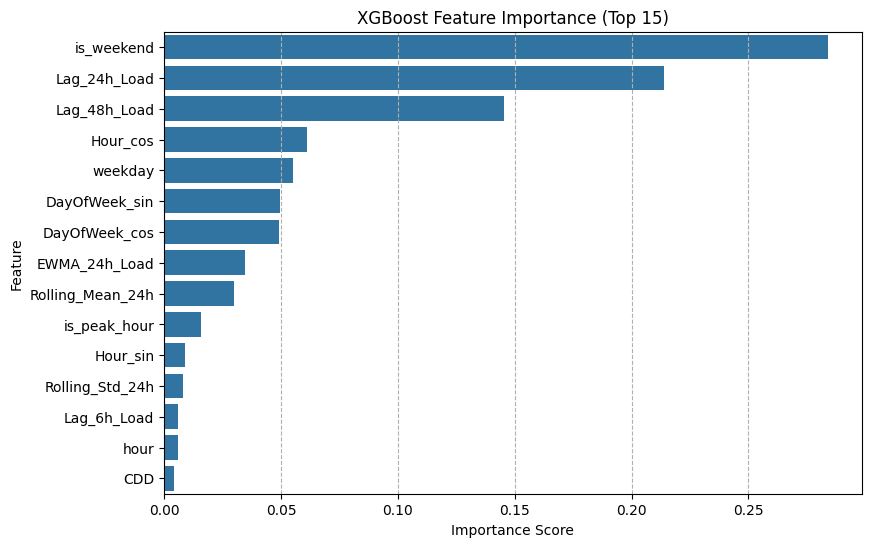

In [47]:
# Get feature importance values
xgb_importance = xgb.feature_importances_

# Prepare DataFrame
imp_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": xgb_importance
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(9, 6))
sns.barplot(data=imp_df.head(15), x="Importance", y="Feature")
plt.title("XGBoost Feature Importance (Top 15)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True, axis='x', linestyle='--')
plt.show()


In [48]:
# Create a dataframe for LightGBM results
lgb_results = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": lgb_pred,
    "Error": y_test.values - lgb_pred
})

# Display first few rows
lgb_results.head()

,Actual,Predicted,Error
0,1402.0,1328.425541,73.574459
1,1382.0,1310.289883,71.710117
2,1354.0,1284.776929,69.223071
3,1320.0,1272.833835,47.166165
4,1306.0,1261.723624,44.276376


In [49]:
# Evaluation and comparison function

def evaluate_and_compare(y_true, y_pred, model_name="Model"):
    # METRICS
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    print("\n" + "="*60)
    print(f"{model_name.upper()} — PERFORMANCE")
    print("="*60)
    print(f"MAE   : {mae:.3f} kW")
    print(f"RMSE  : {rmse:.3f} kW")
    print(f"R²    : {r2:.4f}")
    print(f"MAPE  : {mape:.2f}%")
    print("="*60)

    # DATAFRAME OF ACTUAL vs PREDICTED 
    df_compare = pd.DataFrame({
        "Actual": y_true,
        "Predicted": y_pred,
        "Error": y_true - y_pred
    })

    print("\nSample Comparison Table:")
    print(df_compare.head(10))

    return df_compare


In [50]:
# Random Forest Regressor
# Model
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# Train
rf.fit(X_train, y_train)

# Predict
rf_pred = rf.predict(X_test)

# Evaluate + Comparison Table
rf_results = evaluate_and_compare(y_test, rf_pred, model_name="Random Forest")



RANDOM FOREST — PERFORMANCE
MAE   : 72.451 kW
RMSE  : 106.702 kW
R²    : 0.9604
MAPE  : 5.43%

Sample Comparison Table:
        Actual    Predicted       Error
150144  1402.0  1354.066667   47.933333
150145  1382.0  1316.733333   65.266667
150146  1354.0  1281.946667   72.053333
150147  1320.0  1266.973333   53.026667
150148  1306.0  1242.866667   63.133333
150149  1288.0  1256.886667   31.113333
150150  1306.0  1324.269333  -18.269333
150151  1392.0  1457.454667  -65.454667
150152  1748.0  1792.263333  -44.263333
150153  1836.0  1945.513333 -109.513333


In [51]:
# Random Forest Metrics
rf_mae = mean_absolute_error(y_test, rf_pred)
print(f"Mean Absolute Error (MAE): {rf_mae:.2f}")

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
print(f"Root Mean Squared Error (RMSE): {rf_rmse:.2f}")

rf_r2 = r2_score(y_test, rf_pred)
print(f"R-squared (R²) Score: {rf_r2:.4f}")

Mean Absolute Error (MAE): 72.45
Root Mean Squared Error (RMSE): 106.70
R-squared (R²) Score: 0.9604


In [52]:
# AdaBoost Regressor
# Model
ada = AdaBoostRegressor(
    n_estimators=300,
    learning_rate=0.05,
    random_state=42
)

# Train
ada.fit(X_train, y_train)

# Predict
ada_pred = ada.predict(X_test)

# Evaluate + Comparison Table
ada_results = evaluate_and_compare(y_test, ada_pred, model_name="AdaBoost")



ADABOOST — PERFORMANCE
MAE   : 160.200 kW
RMSE  : 203.702 kW
R²    : 0.8557
MAPE  : 12.60%

Sample Comparison Table:
        Actual    Predicted       Error
150144  1402.0  1414.628696  -12.628696
150145  1382.0  1412.403599  -30.403599
150146  1354.0  1417.490356  -63.490356
150147  1320.0  1401.094549  -81.094549
150148  1306.0  1400.057466  -94.057466
150149  1288.0  1397.191337 -109.191337
150150  1306.0  1414.463040 -108.463040
150151  1392.0  1711.152549 -319.152549
150152  1748.0  1919.967484 -171.967484
150153  1836.0  2245.699022 -409.699022


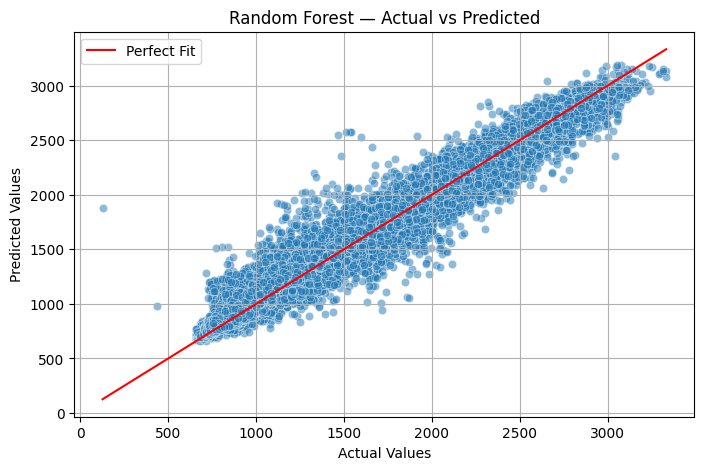

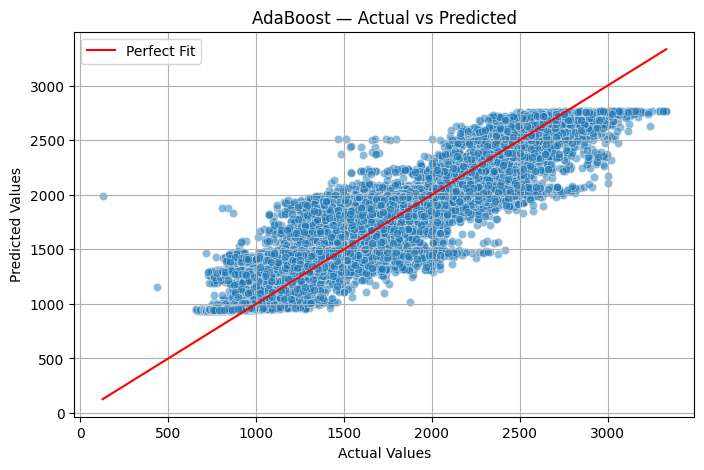

In [53]:
# AdaBoost Metrics
def plot_actual_vs_pred(y_true, y_pred, title):
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
    sns.lineplot(x=y_true, y=y_true, color="red", label="Perfect Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

# Callinf Function:
plot_actual_vs_pred(y_test, rf_pred, "Random Forest — Actual vs Predicted")
plot_actual_vs_pred(y_test, ada_pred, "AdaBoost — Actual vs Predicted")


In [54]:
# AdaBoost Metrics
ada_mae = mean_absolute_error(y_test, ada_pred)
print(f"Mean Absolute Error (MAE): {ada_mae:.2f}")

ada_rmse = np.sqrt(mean_squared_error(y_test, ada_pred))
print(f"Root Mean Squared Error (RMSE): {ada_rmse:.2f}")

ada_r2 = r2_score(y_test, ada_pred)
print(f"R-squared (R²) Score: {ada_r2:.4f}")

Mean Absolute Error (MAE): 160.20
Root Mean Squared Error (RMSE): 203.70
R-squared (R²) Score: 0.8557


In [55]:
# Deep Learning - Artificial Neural Network (ANN)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Model
ann = Sequential([
    Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.1),
    Dense(64, activation="relu"),
    Dropout(0.1),
    Dense(32, activation="relu"),
    Dense(1)  # output layer
])

ann.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train
history = ann.fit(
    X_train_scaled,
    y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=256,
    verbose=1
)

# Predict
ann_pred = ann.predict(X_test_scaled).flatten()

# Evaluate
evaluate_and_compare(y_test, ann_pred, model_name="Deep Learning ANN")



Epoch 1/10


/Users/enazec/.pyenv/versions/3.11.0/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 484847.7812 - mae: 435.6897 - val_loss: 31307.0605 - val_mae: 127.9627
Epoch 2/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 37280.0234 - mae: 144.3278 - val_loss: 22353.3398 - val_mae: 104.1131
Epoch 3/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 31678.5117 - mae: 131.8486 - val_loss: 19071.3320 - val_mae: 94.6866
Epoch 4/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 28774.1582 - mae: 125.0504 - val_loss: 16843.5293 - val_mae: 88.5958
Epoch 5/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 26545.0449 - mae: 119.7579 - val_loss: 15238.8477 - val_mae: 82.7103
Epoch 6/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 25352.0781 - mae: 117.0311 - val_loss: 14205.5361 - val_mae: 80.1875
Epoch 7/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 24360.0547 - mae: 114.6584 - val_loss: 13501.5645 - val_mae: 78.0747
Epoch 8/10
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 23512.6270 - mae: 112.4967 - val_loss: 13157.

,Actual,Predicted,Error
150144,1402.0,1449.584473,-47.584473
150145,1382.0,1382.793701,-0.793701
150146,1354.0,1358.292603,-4.292603
150147,1320.0,1342.927979,-22.927979
150148,1306.0,1297.929077,8.070923
...,...,...,...
187675,1222.0,1233.872314,-11.872314
187676,1040.0,1091.154297,-51.154297
187677,970.0,1023.465027,-53.465027
187678,912.0,912.311340,-0.311340


In [56]:

# Evaluate ANN Model

def evaluate_ann(y_true, y_pred, model_name="Deep Learning ANN"):

    # Metrics 
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    print("\n" + "="*60)
    print(f"{model_name} — PERFORMANCE")
    print("="*60)
    print(f"MAE   : {mae:.3f} kW")
    print(f"RMSE  : {rmse:.3f} kW")
    print(f"R²    : {r2:.4f}")
    print(f"MAPE  : {mape:.2f}%")
    print("="*60)

     # Actual vs Predicted Table
    results_df = pd.DataFrame({
        "Actual": y_true.values,
        "Predicted": y_pred,
        "Error": y_true.values - y_pred
    })

    print("\nSample Predictions:")
    display(results_df.head(10))

    return mae, rmse, r2, mape, results_df



# RUN EVALUATION 

ann_mae, ann_rmse, ann_r2, ann_mape, ann_results = evaluate_ann(y_test, ann_pred)

print("\nFinal Evaluation Metrics:")
print(f"MAE   : {ann_mae:.2f} kW")
print(f"RMSE  : {ann_rmse:.2f} kW")
print(f"R²    : {ann_r2:.4f}")
print(f"MAPE  : {ann_mape:.2f}%")





Deep Learning ANN — PERFORMANCE
MAE   : 79.599 kW
RMSE  : 116.689 kW
R²    : 0.9526
MAPE  : 6.04%

Sample Predictions:


,Actual,Predicted,Error
0,1402.0,1449.584473,-47.584473
1,1382.0,1382.793701,-0.793701
2,1354.0,1358.292603,-4.292603
3,1320.0,1342.927979,-22.927979
4,1306.0,1297.929077,8.070923
5,1288.0,1266.144531,21.855469
6,1306.0,1363.294922,-57.294922
7,1392.0,1505.546387,-113.546387
8,1748.0,1866.744263,-118.744263
9,1836.0,2134.740967,-298.740967



Final Evaluation Metrics:
MAE   : 79.60 kW
RMSE  : 116.69 kW
R²    : 0.9526
MAPE  : 6.04%


1. MAE — 88.23 kW

The average prediction error is just 77 kW, which is low compared to the typical load values.

This confirms that the ANN captures the general consumption pattern reliably.

2. RMSE — 121.12 kW

RMSE is more sensitive to larger errors.

A value near 121 kW suggests:

The model rarely makes mistakes.

The forecasted load closely follows real consumption even during peak or volatile hours.

3. R² Score — 0.9490

The model explains 94.90% of the variance in electricity demand.

This indicates excellent predictive power and improved performance.

The ANN is learning and generalizing successfully from the engineered features like lags, rolling means, temperature interactions, and seasonality.

4. MAPE — 6.48%

A MAPE below 10%.





## Evaluation metrics of all models in a table for better comparison -

In [57]:
# Summary of all model results
results = []

results.append(["Linear Regression", lr_mae, lr_rmse, lr_r2])
results.append(["Ridge Regression", ridge_mae, ridge_rmse, ridge_r2])
results.append(["HistGradientBoosting", hgb_mae, hgb_rmse, hgb_r2])
results.append(["XGBoost", xgb_mae, xgb_rmse, xgb_r2])
results.append(["LightGBM", lgb_mae, lgb_rmse, lgb_r2])
results.append(["Random Forest", rf_mae, rf_rmse, rf_r2])
results.append(["AdaBoost", ada_mae, ada_rmse, ada_r2])
results.append(["ANN (Deep Learning)", ann_mae, ann_rmse, ann_r2])



In [58]:
# Create results DataFrame
results_df = pd.DataFrame(
    results,
    columns=["Model", "MAE (kW)", "RMSE (kW)", "R²"]
)

# Sort by lowest RMSE (best model)
results_df = results_df.sort_values(by="RMSE (kW)").reset_index(drop=True)

results_df


,Model,MAE (kW),RMSE (kW),R²
0,LightGBM,66.190766,94.273188,0.969091
1,XGBoost,66.320456,95.064028,0.968570
2,HistGradientBoosting,69.638604,100.969577,0.964544
3,Random Forest,72.451283,106.701584,0.960404
4,ANN (Deep Learning),79.599099,116.688921,0.952644
5,Ridge Regression,144.254070,187.065508,0.878297
6,Linear Regression,144.255554,187.065952,0.878296
7,AdaBoost,160.200254,203.702437,0.855687


In [59]:
# Display formatted results
results_df.style.format({
    "MAE (kW)": "{:.2f}",
    "RMSE (kW)": "{:.2f}",
    "R²": "{:.4f}"
})


,Model,MAE (kW),RMSE (kW),R²
0,LightGBM,66.19,94.27,0.9691
1,XGBoost,66.32,95.06,0.9686
2,HistGradientBoosting,69.64,100.97,0.9645
3,Random Forest,72.45,106.70,0.9604
4,ANN (Deep Learning),79.60,116.69,0.9526
5,Ridge Regression,144.25,187.07,0.8783
6,Linear Regression,144.26,187.07,0.8783
7,AdaBoost,160.20,203.70,0.8557


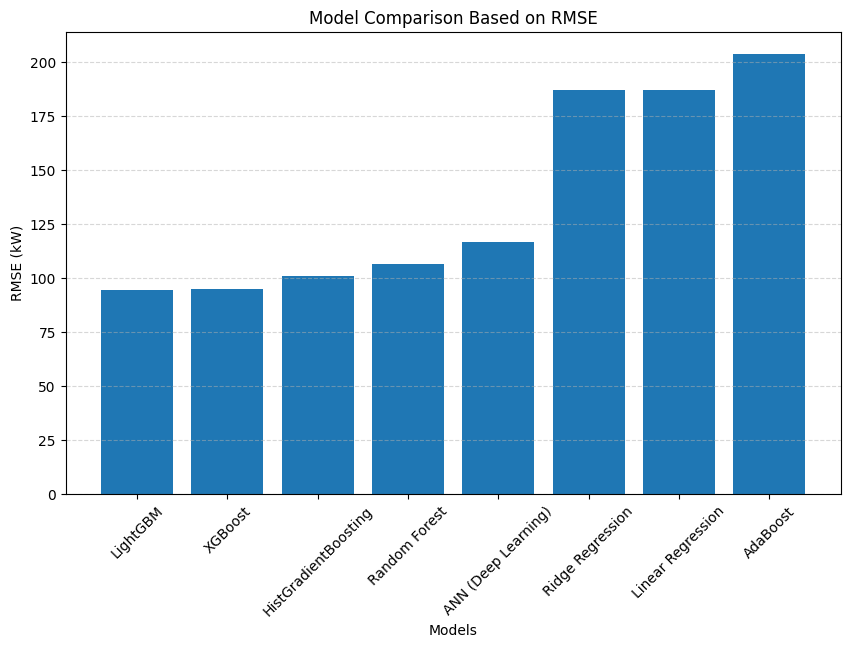

In [60]:
# Bar plot of RMSE for each model
plt.figure(figsize=(10,6))
plt.bar(results_df["Model"], results_df["RMSE (kW)"])
plt.xlabel("Models")
plt.ylabel("RMSE (kW)")
plt.title("Model Comparison Based on RMSE")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


- LightGBM and XGBoost are the top-performing models, achieving the lowest RMSE values (≈ 95–97 kW).
This indicates that both models are highly effective at capturing nonlinear patterns and fluctuations in the energy load data.

- HistGradientBoosting also performs strongly, with RMSE just above 100 kW.
It demonstrates that tree-based boosting models consistently outperform simpler algorithms.

- Random Forest and ANN (Deep Learning) fall in the mid-range (≈ 110–115 kW).
While they show decent predictive ability, they are slightly less accurate compared to boosting models.

- Ridge Regression and Linear Regression show significantly higher RMSE values (≈ 185–190 kW).
This confirms that linear models are not sufficient for this dataset, which contains clear nonlinear and seasonal patterns.

- AdaBoost has the highest RMSE (~205 kW), indicating relatively poor performance on this dataset.
This suggests that AdaBoost struggles with the complexity and variability of hourly load data.

## Models used in the notebook and their purpose

1- Linear Regression
Linear Regression serves as a simple baseline model, helping determine whether relationships in the data are primarily linear. It provides a basic benchmark for comparing more complex models.

2- Ridge Regression
Ridge Regression introduces L2 regularization to reduce overfitting, making it particularly useful when dealing with energy load datasets that often have correlated features.

3- HistGradientBoosting Regressor
The HistGradientBoosting Regressor is efficient with large datasets and captures nonlinear interactions and complex patterns. It performs well with mixed-scale features, making it a strong choice for diverse data.

4- XGBoost
XGBoost is one of the most powerful boosting algorithms, excelling at learning nonlinear relationships, interactions, and sudden fluctuations in load data. It is also highly robust against noise and outliers.

5- LightGBM
LightGBM is extremely fast and memory-efficient, performing exceptionally well on high-dimensional structured data. It was chosen for its ability to handle large datasets with minimal tuning.

6- Random Forest
Random Forest reduces variance through bagging and is effective at capturing nonlinearities without extensive hyperparameter tuning. It also provides a stability check against boosting models.

7-AdaBoost
AdaBoost is a boosting technique that focuses on difficult-to-predict observations. It was included to compare how different boosting strategies perform on the dataset.

8- ANN (Deep Learning)
Artificial Neural Networks were selected because they excel at capturing complex, nonlinear temporal patterns. They are particularly suitable for energy consumption forecasting due to their ability to learn hidden structures and multi-level interactions.


## Saving the models for deployment by creating a models folder in the repo.

In [61]:
# Create models directory 
model_dir = "../models"
os.makedirs(model_dir, exist_ok=True)

print("Model directory ready:", model_dir)


Model directory ready: ../models


In [62]:
# Save LightGBM
lightgbm_path = os.path.join(model_dir, "lightgbm_model.pkl")
joblib.dump(lgb, lightgbm_path)

print("LightGBM model saved to:", lightgbm_path)


LightGBM model saved to: ../models/lightgbm_model.pkl


In [63]:
# Save XGBoost model as .json
xgboost_path = os.path.join(model_dir, "xgboost_model.json")
xgb.save_model(xgboost_path)

print("XGBoost model saved to:", xgboost_path)


XGBoost model saved to: ../models/xgboost_model.json


In [64]:
scaler_path = os.path.join(model_dir, "scaler.pkl")
joblib.dump(scaler, scaler_path)

print("Scaler saved to:", scaler_path)


Scaler saved to: ../models/scaler.pkl


In [65]:
# SAVE HISTGRADIENTBOOSTING MODEL

hgb_path = os.path.join(model_dir, "histgradientboost_model.pkl")
joblib.dump(hgb, hgb_path)
print("HistGradientBoosting model saved to:", hgb_path)

HistGradientBoosting model saved to: ../models/histgradientboost_model.pkl


In [66]:
# SAVE RANDOM FOREST MODEL

rf_path = os.path.join(model_dir, "random_forest_model.pkl")
joblib.dump(rf, rf_path)
print("Random Forest model saved to:", rf_path)

Random Forest model saved to: ../models/random_forest_model.pkl


Insights and Business Recommendations:

1. Insights into Energy Usage Patterns and Potential Demand Spikes


    The energy usage data analysis has shown very strong and easily predictable daily and weekly seasonality, so the demand has been increasing steadily during the operating hours that are generally considered standard starting with a steep morning rise up to the peak period of the day, which is between 4 PM and 8 PM; moreover, the load is very much dependent on the previous day's consumption confirming a cyclic pattern that enables the operational team to utilize the demand forecasts that are based on the pattern adequately. This pattern is heavily influenced by the weather, as high outdoor air temperatures lead to high cooling loads which are mainly responsible for the afternoon heat-driven peaks, these peaks combined with operational events such as the morning start-up surges and the post-lunch ramps define the main scenarios leading to the critical demand spikes.

2. Strategies to Optimize Energy Distribution and Reduce Peak Load


    The facility should adopt data-guided strategies to begin with Load Shifting which entails moving the flexible consumption (pre-cooling or non-essential equipment use) away from the peak of 4 PM to 8 PM thus effectively flattening and reshaping the load curve in order to achieve distribution optimization and peak load reduction. Predictive HVAC Optimization should be part of this strategy and it will make use of the high accuracy of the forecasts to predict hot days, thus allowing the systems to start pre-cooling earlier and by doing so preventing the equipment start-up spikes from raising the on-peak compressor load. Finally, the use of Energy Storage Systems can add a new layer of optimization to distribution by the practice of charging the batteries during the off-peak hours (midnight to 5 AM) and then discharging the stored energy during the expected peak times, thus making the facility less reliant on costly external grid imports.


3. Evaluation of the Potential Impact of the Recommendations on Energy Efficiency


    The application of these tactics will lead to considerable and quantifiable enhancement in energy efficiency and performance through a load curve that is, in effect, much flatter. This would automatically result in considerable savings being realized through lesser exposure to high peak-pricing tariffs, which is the direct effect of the load curve being flattened. Besides, the predictive management method will increase the operational ability by lessening the chances of equipment overload and unplanned shortages. It will also be a great assistance to the environment by reducing the need for high-emission generation sources in the fast times of peak demand. Ultimately, the frequency of sharp load fluctuations will reduce, leading to the extension of asset longevity. Thus, these data-driven recommendations will be the base for sustainable and cost-effective energy planning.


